# Evaluating Agents Behaviors
Learning to estimate the value of policies

**Value Function** (or Action-Value function): Refers to the expectation of returns.

In [1]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import gym, gym_walk, gym_aima
from tqdm import tqdm_notebook as tqdm

from itertools import cycle, count

import random
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import warnings ; warnings.filterwarnings('ignore')

SEEDS = (12, 34, 56, 78, 90)
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (30, 16),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [3]:
def policy_evaluation(pi, P, gamma=1.0, theta=1e-10):
    prev_V = np.zeros(len(P), dtype=np.float64)
    while True:
        V = np.zeros(len(P), dtype=np.float64)
        for s in range(len(P)):
            for prob, next_state, reward, done in P[s][pi(s)]:
                V[s] += prob * (reward + gamma * prev_V[next_state] * (not done))
        if np.max(np.abs(prev_V - V)) < theta:
            break
        prev_V = V.copy()
    return V

In [4]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [5]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [6]:
def probability_success(env, pi, goal_state, n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        while not done and steps < max_steps:
            state, _, done, h = env.step(pi(state))
            steps += 1
        print(f"Done: {done} State: {state}")
        results.append(state == goal_state)
    return np.sum(results)/len(results)*100

In [7]:
def mean_return(env, gamma, pi, n_episodes=100, max_steps=200):
    random.seed(123); np.random.seed(123) ; env.seed(123)
    results = []
    for _ in range(n_episodes):
        state, done, steps = env.reset(), False, 0
        results.append(0.0)
        while not done and steps < max_steps:
            state, reward, done, _ = env.step(pi(state))
            results[-1] += (gamma**steps * reward)
            steps += 1
    return np.mean(results)

In [8]:
def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-","--",":","-."])
    legends = []

    valid_values = np.argwhere(V_true >= limit_value).squeeze()
    items_idxs = np.random.choice(valid_values, 
                                  min(len(valid_values), limit_items), 
                                  replace=False)
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_true.T):
            if i not in items_idxs:
                continue
            
            label = 'v({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            plt.text(int(len(V_track)*1.02), V_true[i]+.01, label)

    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue

        line_type = next(linecycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)
        
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.show()

## Monte-Carlo learning

$V_t(S_t) = V_{T-1}(S_t) + \alpha_t \big[ \overbrace{\underbrace{G_{t:T}}_{\text{MC target}} - V_{T-1}(S_t)}^{\text{MC Error}} \big]$

In [9]:
def decay_schedule(init_value, min_value,
                    decay_ratio, max_steps,
                    log_start=-2, log_base=10):
    
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps,
                            base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / \
                    (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

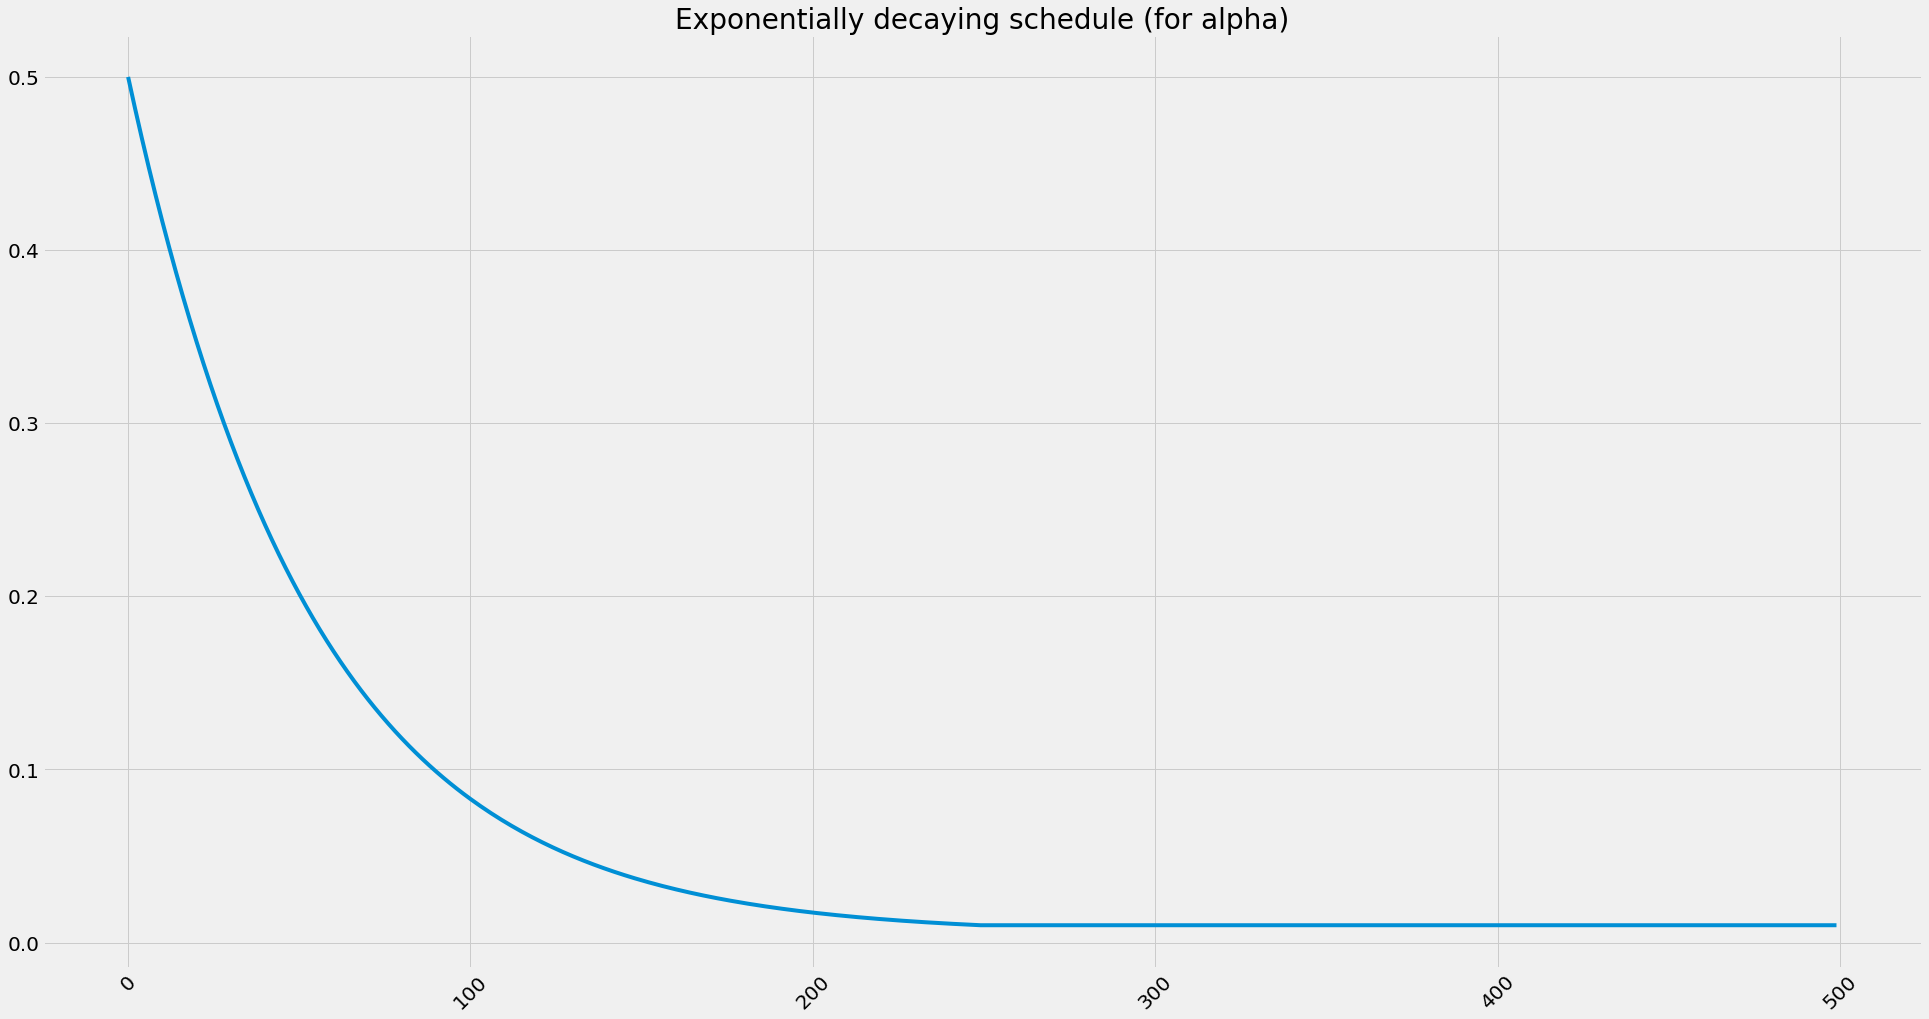

In [10]:
plt.plot(decay_schedule(0.5, 0.01, 0.5, 500))
plt.title('Exponentially decaying schedule (for alpha)')
plt.xticks(rotation=45)
plt.show()

In [11]:
def generate_trajectory(pi, env, max_steps=20):
    done, trajectory = False, []

    while not done:
        state = env.reset()

        for t in count():
            action = pi(state)

            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state, done)

            trajectory.append(experience)

            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            
            state = next_state
    
    return np.array(trajectory, np.object)

In [12]:
def mc_prediction(pi, env, 
                gamma=0.1,
                init_alpha=0.5,
                min_alpha=0.01,
                alpha_decay_ratio=0.3,
                n_episodes=500,
                max_steps=100,
                first_visit=True
                ):

    nS = env.observation_space.n

    discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False)
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    
    V = np.zeros(nS)
    V_track = np.zeros((n_episodes, nS))
    targets = {state:[] for state in range(nS)}

    for e in tqdm(range(n_episodes), leave=False):
        trajectory = generate_trajectory(pi, env, max_steps)
        visited = np.zeros(nS, dtype=np.bool)

        for t, (state, _, reward, _, _) in enumerate(trajectory):
            if visited[state] and first_visit:
                continue
            visited[state] = True
            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            targets[state].append(G)
            mc_error = G - V[state]
            V[state] = V[state] + alphas[e] * mc_error
        
        V_track[e] = V
    
    return V.copy(), V_track, targets


In [13]:
env = gym.make('RandomWalk-v0')
init_state = env.reset()
goal_state = 6
gamma = 1.0
n_episodes = 500
P = env.env.P

LEFT, RIGHT = range(2)
pi = lambda s: {
    0:LEFT, 1:LEFT, 2:LEFT, 3:LEFT, 4:LEFT, 5:LEFT, 6:LEFT
}[s]
V_true = policy_evaluation(pi, P, gamma=gamma)


print_state_value_function(V_true, P, n_cols=7)
print()
print_policy(pi, P, action_symbols=('<', '>'), n_cols=7)

print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}.'.format(
    probability_success(env, pi, goal_state=goal_state), 
    mean_return(env, gamma, pi)))

State-value function:
|           | 01  0.167 | 02  0.333 | 03    0.5 | 04  0.667 | 05  0.833 |           |

Policy:
|           | 01      < | 02      < | 03      < | 04      < | 05      < |           |
Reaches goal 44.00%. Obtains an average return of 0.4400.


In [14]:
%%capture
V_fvmcs, V_track_fvmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed)
    np.random.seed(seed)
    env.seed(seed)
    V_fvmc, V_track_fvmc, targets_fvmc = mc_prediction(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_fvmcs.append(V_fvmc)
    V_track_fvmcs.append(V_track_fvmc)
V_fvmc, V_track_fvmc = np.mean(V_fvmcs, axis=0), np.mean(V_track_fvmcs, axis=0)
del V_fvmcs ; del V_track_fvmcs

In [15]:
print_state_value_function(V_fvmc, P, n_cols=7)
print()
print_state_value_function(V_fvmc - V_true, P, n_cols=7, title='State-value function errors:')

State-value function:
|           | 01  0.181 | 02   0.35 | 03  0.508 | 04  0.687 | 05  0.845 |           |

State-value function errors:
|           | 01  0.015 | 02  0.016 | 03  0.008 | 04   0.02 | 05  0.011 |           |


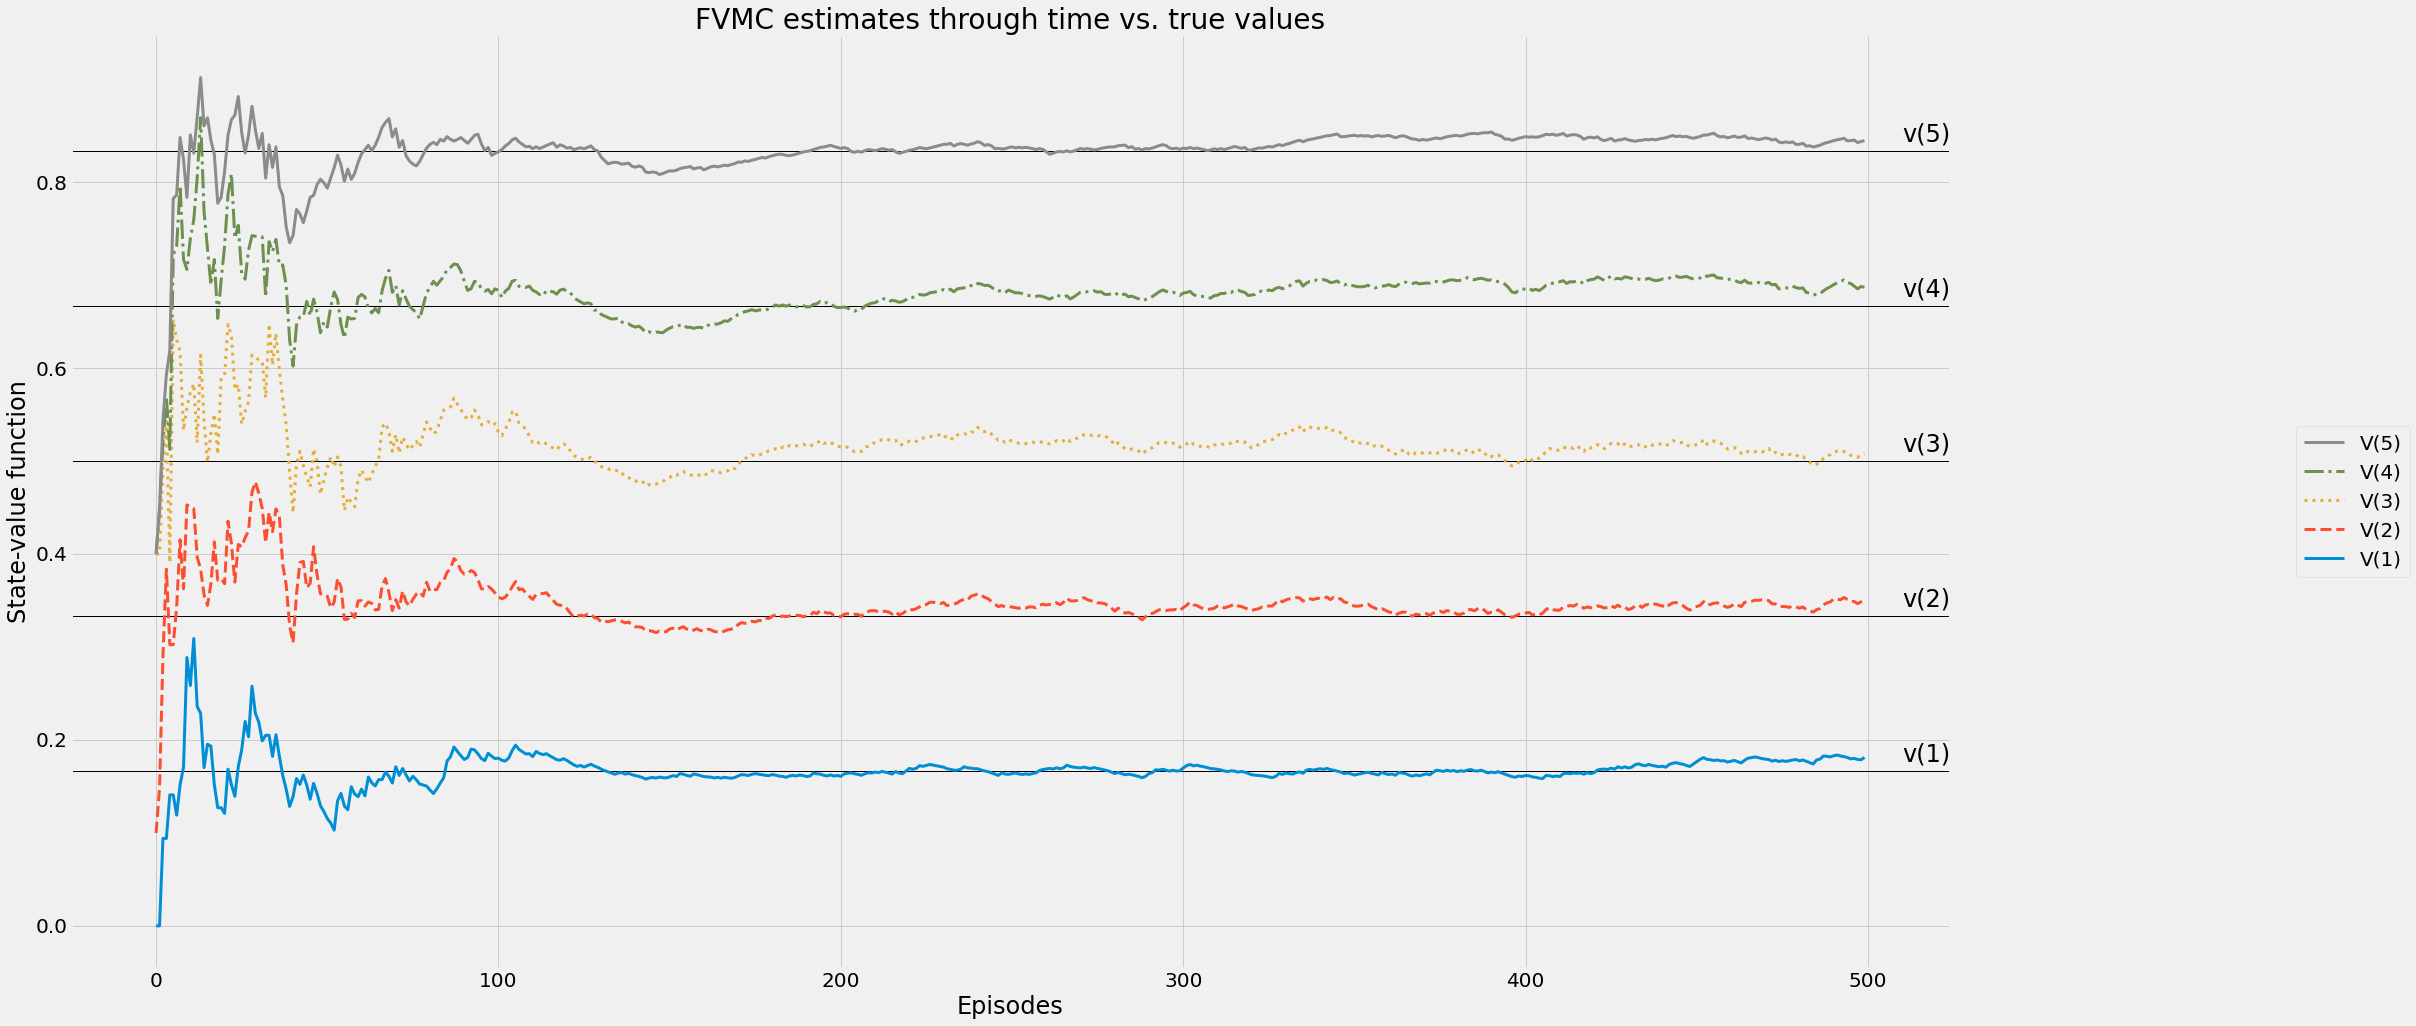

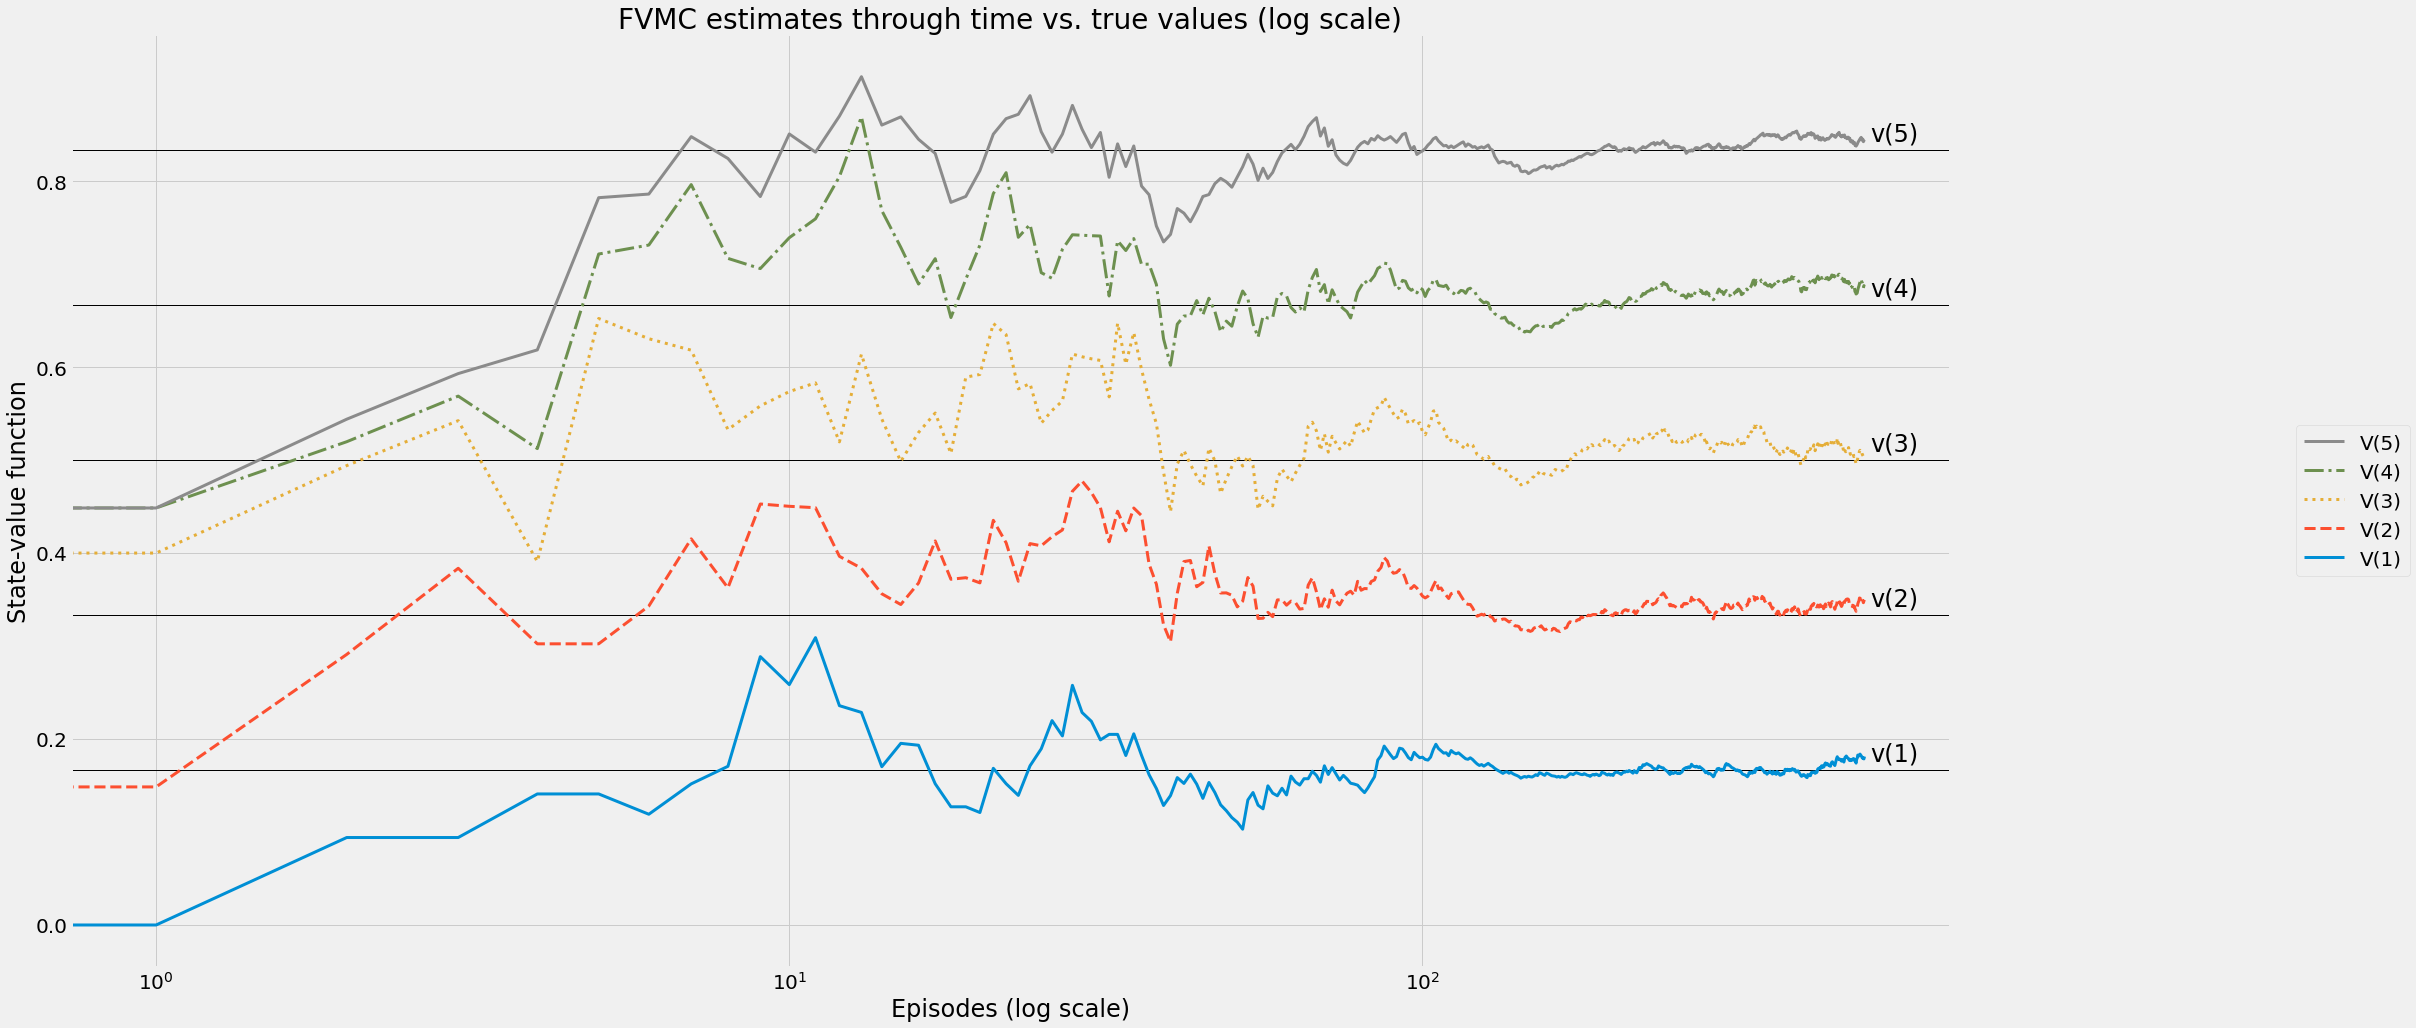

In [16]:
plot_value_function('FVMC estimates through time vs. true values', V_track_fvmc, V_true, log=False)
plot_value_function('FVMC estimates through time vs. true values (log scale)', V_track_fvmc, V_true, log=True)

## Temporal-difference Learning

$V_{t+1} = V_t(S_t) + \alpha_t \Big[ \overbrace{\underbrace{R_{t+1} + \gamma V_t(S_{t+1})}_{\text{TD target}} - V_t(S_t)}^{\text{TD Error}}\Big]$

In [17]:
def td(pi,
        env,
        gamma=1.0,
        init_alpha=0.5,
        min_alpha=0.01,
        alpha_decay_ratio=0.3,
        n_episodes=500):

    nS = env.observation_space.n
    V = np.zeros(nS)
    V_track = np.zeros((n_episodes, nS))
    targets = {state: [] for state in range(nS)}
    alphas = decay_schedule(
        init_alpha, min_alpha,
        alpha_decay_ratio, n_episodes
    )

    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset(), False

        while not done:
            action = pi(state)
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * V[next_state] * (not done)

            targets[state].append(td_target)

            td_error = td_target - V[state]
            V[state] = V[state] + alphas[e] * td_error
            state = next_state
        
        V_track[e] = V
    return V, V_track, targets

In [18]:
%%capture
V_tds, V_track_tds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed)
    np.random.seed(seed)
    env.seed(seed)
    V_td, V_track_td, targets_td = td(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tds.append(V_td)
    V_track_tds.append(V_track_td)
V_td, V_track_td = np.mean(V_tds, axis=0), np.mean(V_track_tds, axis=0)
del V_tds ; del V_track_tds

In [19]:
print_state_value_function(V_td, P, n_cols=7)
print()
print_state_value_function(V_td - V_true, P, n_cols=7, title='State-value function errors:')

State-value function:
|           | 01  0.176 | 02  0.335 | 03  0.506 | 04  0.684 | 05  0.844 |           |

State-value function errors:
|           | 01  0.009 | 02  0.001 | 03  0.006 | 04  0.017 | 05  0.011 |           |


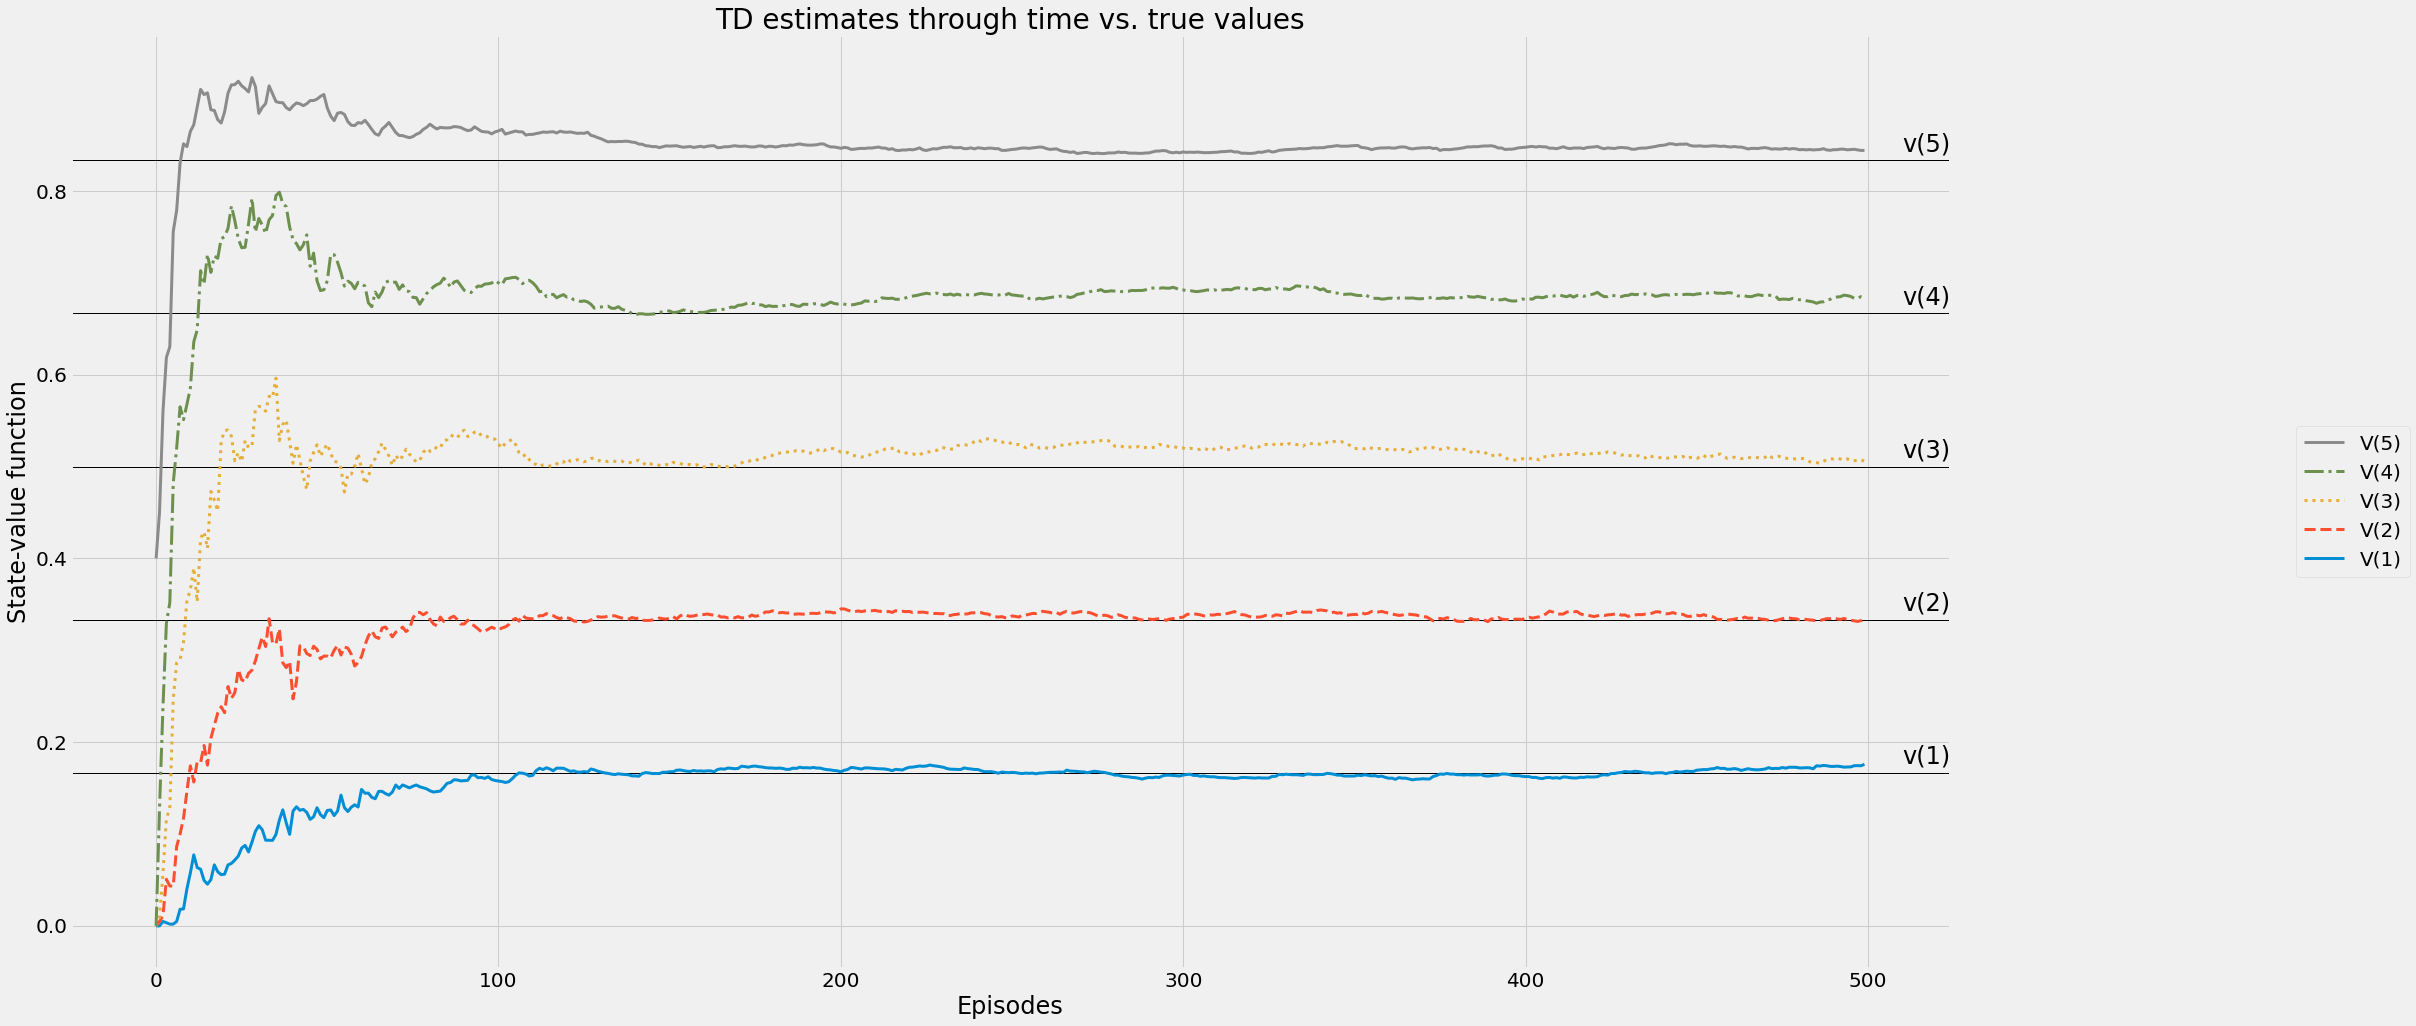

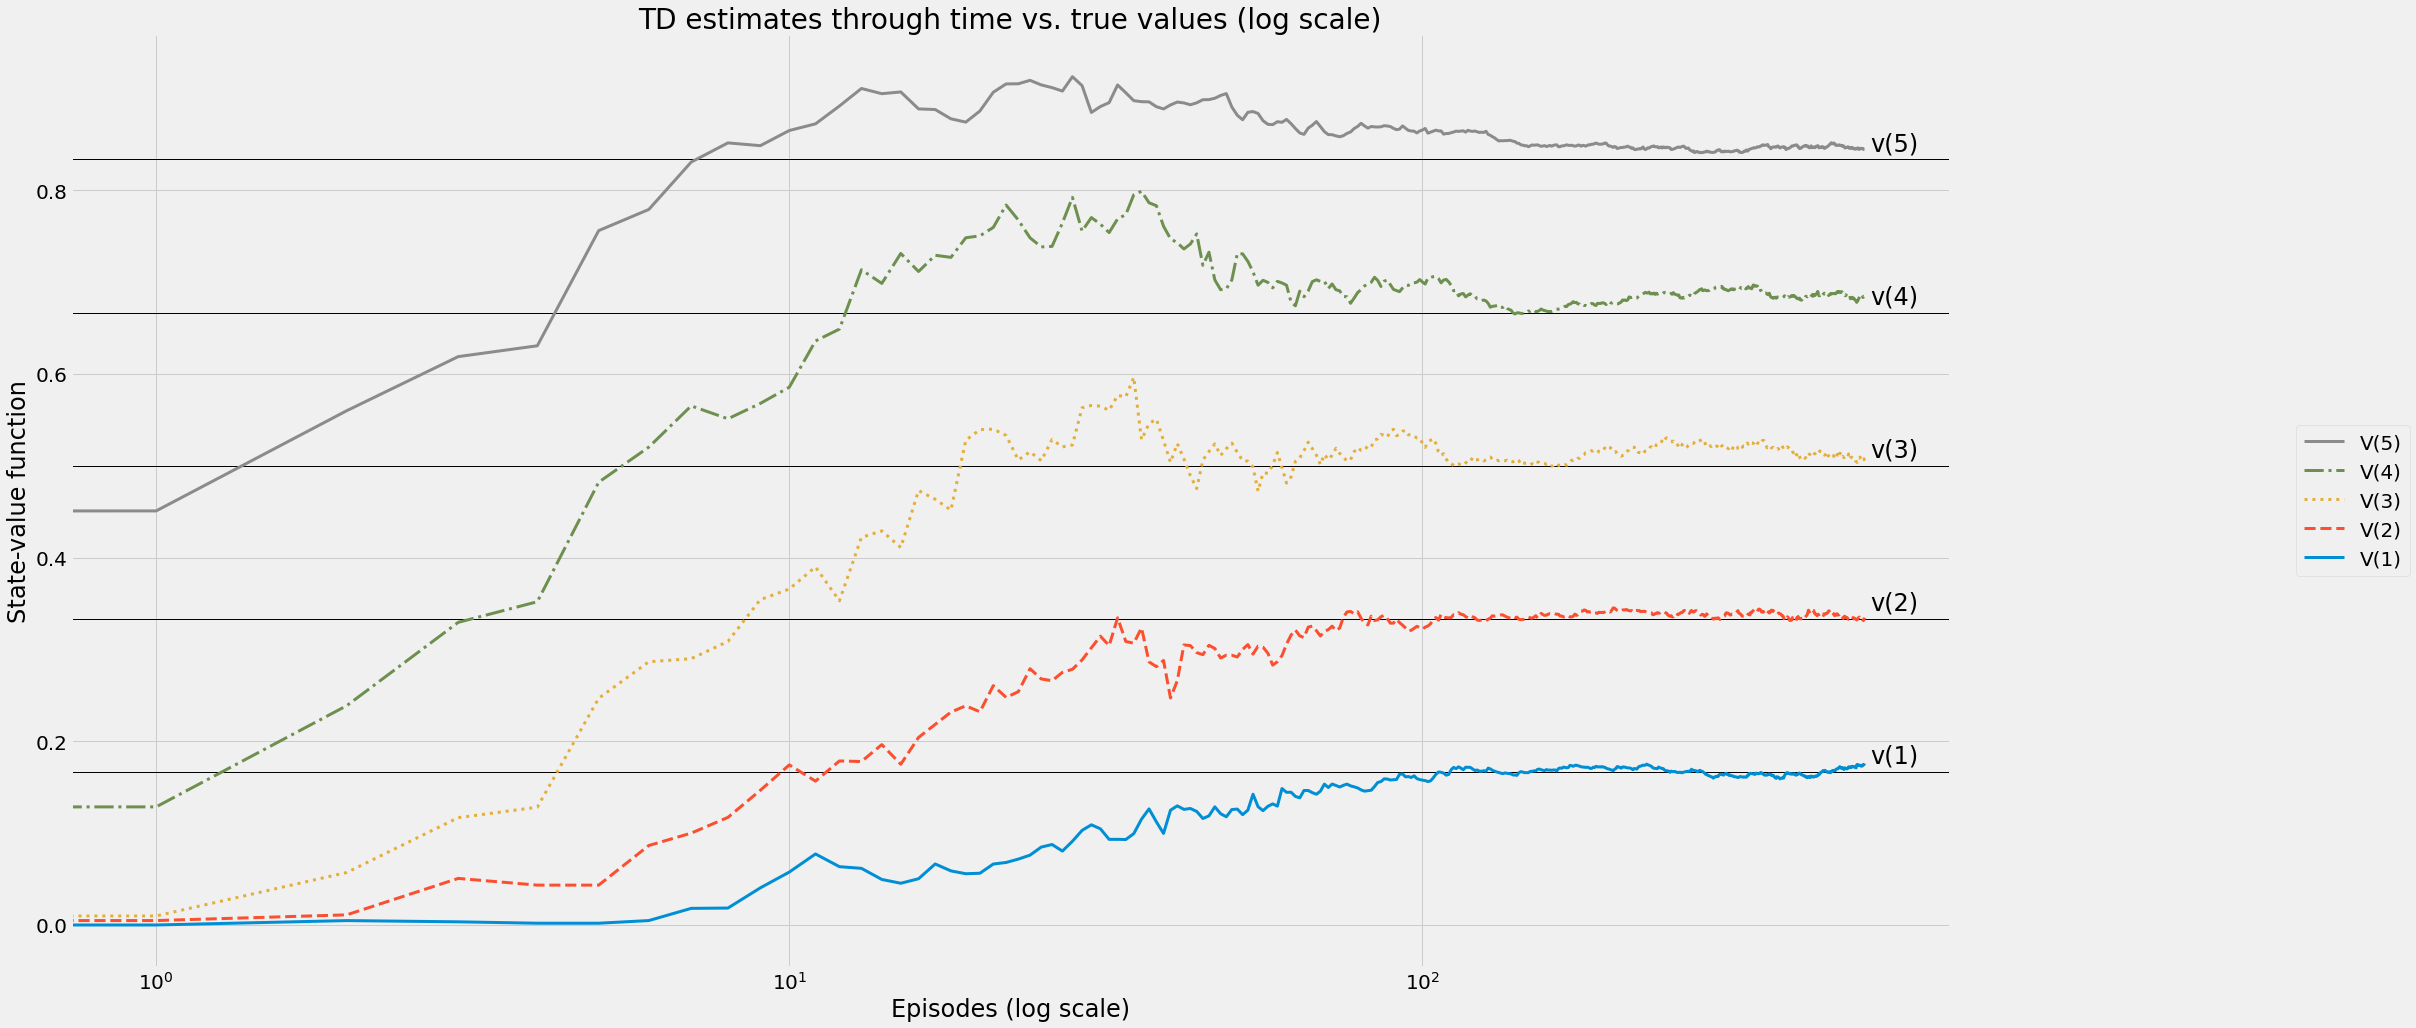

In [20]:
plot_value_function('TD estimates through time vs. true values', V_track_td, V_true, log=False)
plot_value_function('TD estimates through time vs. true values (log scale)', V_track_td, V_true, log=True)

## Comparing TD to MC

MC and TD both nearly converge to the true state-value function

**MC estimates are noisy**: MC estimates jump around the true values. This is because of the high variance of the mc targets  
**TD estimates are off-target**: TD targets are low variance, though biased. They use an estimated return for target

## N-step Temporal-Difference learning

$G_{t:t+n} = R_{t+1} + \dots + \gamma^{n-1} R_{t+n} + \gamma^n V_{t + n - 1}(S_{t+n})$

$V_{t+n}(S_t) = V_{t + n - 1}(S_t) + \alpha_t \Big[ \overbrace{\underbrace{G_{t:t + n}}_{\text{n-step target}} - V_{t + n - 1}(S_t)}^{\text{n-step error}} \Big]$

In [21]:
def ntd(pi,
        env,
        gamma=1.0,
        init_alpha=0.5,
        min_alpha=0.01,
        alpha_decay_ratio=0.5,
        n_step=3,
        n_episodes=500):

    nS = env.observation_space.n
    V = np.zeros(nS)
    V_track = np.zeros((n_episodes, nS))
    alphas = decay_schedule(
        init_alpha, min_alpha,
        alpha_decay_ratio, n_episodes
    )
    
    """
        In MC the discounts goes for max_steps
        In TD there are no discounts, only the bootstrapping estimate
        In N-TD the discounts go to n_step + 1, and then
        the boostrapping estimate for the rest of max_steps
    """
    discounts = np.logspace(
        0, n_step + 1, num=n_step+1, base=gamma, endpoint=False
    )

    for e in tqdm(range(n_episodes), leave=False):

        # path holds the n-step most recent experiences
        # to be used in the n-step target
        state, done, path = env.reset(), False, []

        while not done or path is not None:

            # remove the oldest experience to make room
            # for the current experience
            path = path[1:]

            while not done and len(path) < n_step:
                action = pi(state)
                next_state, reward, done, _ = env.step(action)
                experience = (state, reward, next_state, done)
                path.append(experience)

                state = next_state

                if done:
                    break
            
            n = len(path)
            est_state = path[0][0]
            rewards = np.array(path)[:,1]

            # vector of the last n-step discounted rewards
            partial_return = discounts[:n] * rewards

            # boostrapping value
            bs_val = discounts[-1] * V[next_state] * (not done)
            ntd_target = np.sum(np.append(partial_return, bs_val))
            ntd_error = ntd_target - V[est_state]
            V[est_state] = V[est_state] + alphas[e] * ntd_error

            # check terminal state
            if len(path) == 1 and path[0][3]:
                path = None
        
        V_track[e] = V
    
    return V, V_track

In [22]:
%%capture
V_ntds, V_track_ntds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed)
    np.random.seed(seed)
    env.seed(seed)
    V_ntd, V_track_ntd = ntd(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_ntds.append(V_ntd)
    V_track_ntds.append(V_track_ntd)
V_ntd, V_track_ntd = np.mean(V_ntds, axis=0), np.mean(V_track_ntds, axis=0)
del V_ntds ; del V_track_ntds

In [23]:
print_state_value_function(V_ntd, P, n_cols=7)
print()
print_state_value_function(V_ntd - V_true, P, n_cols=7, title='State-value function errors:')

State-value function:
|           | 01  0.178 | 02  0.341 | 03  0.507 | 04   0.68 | 05   0.84 |           |

State-value function errors:
|           | 01  0.012 | 02  0.008 | 03  0.007 | 04  0.013 | 05  0.007 |           |


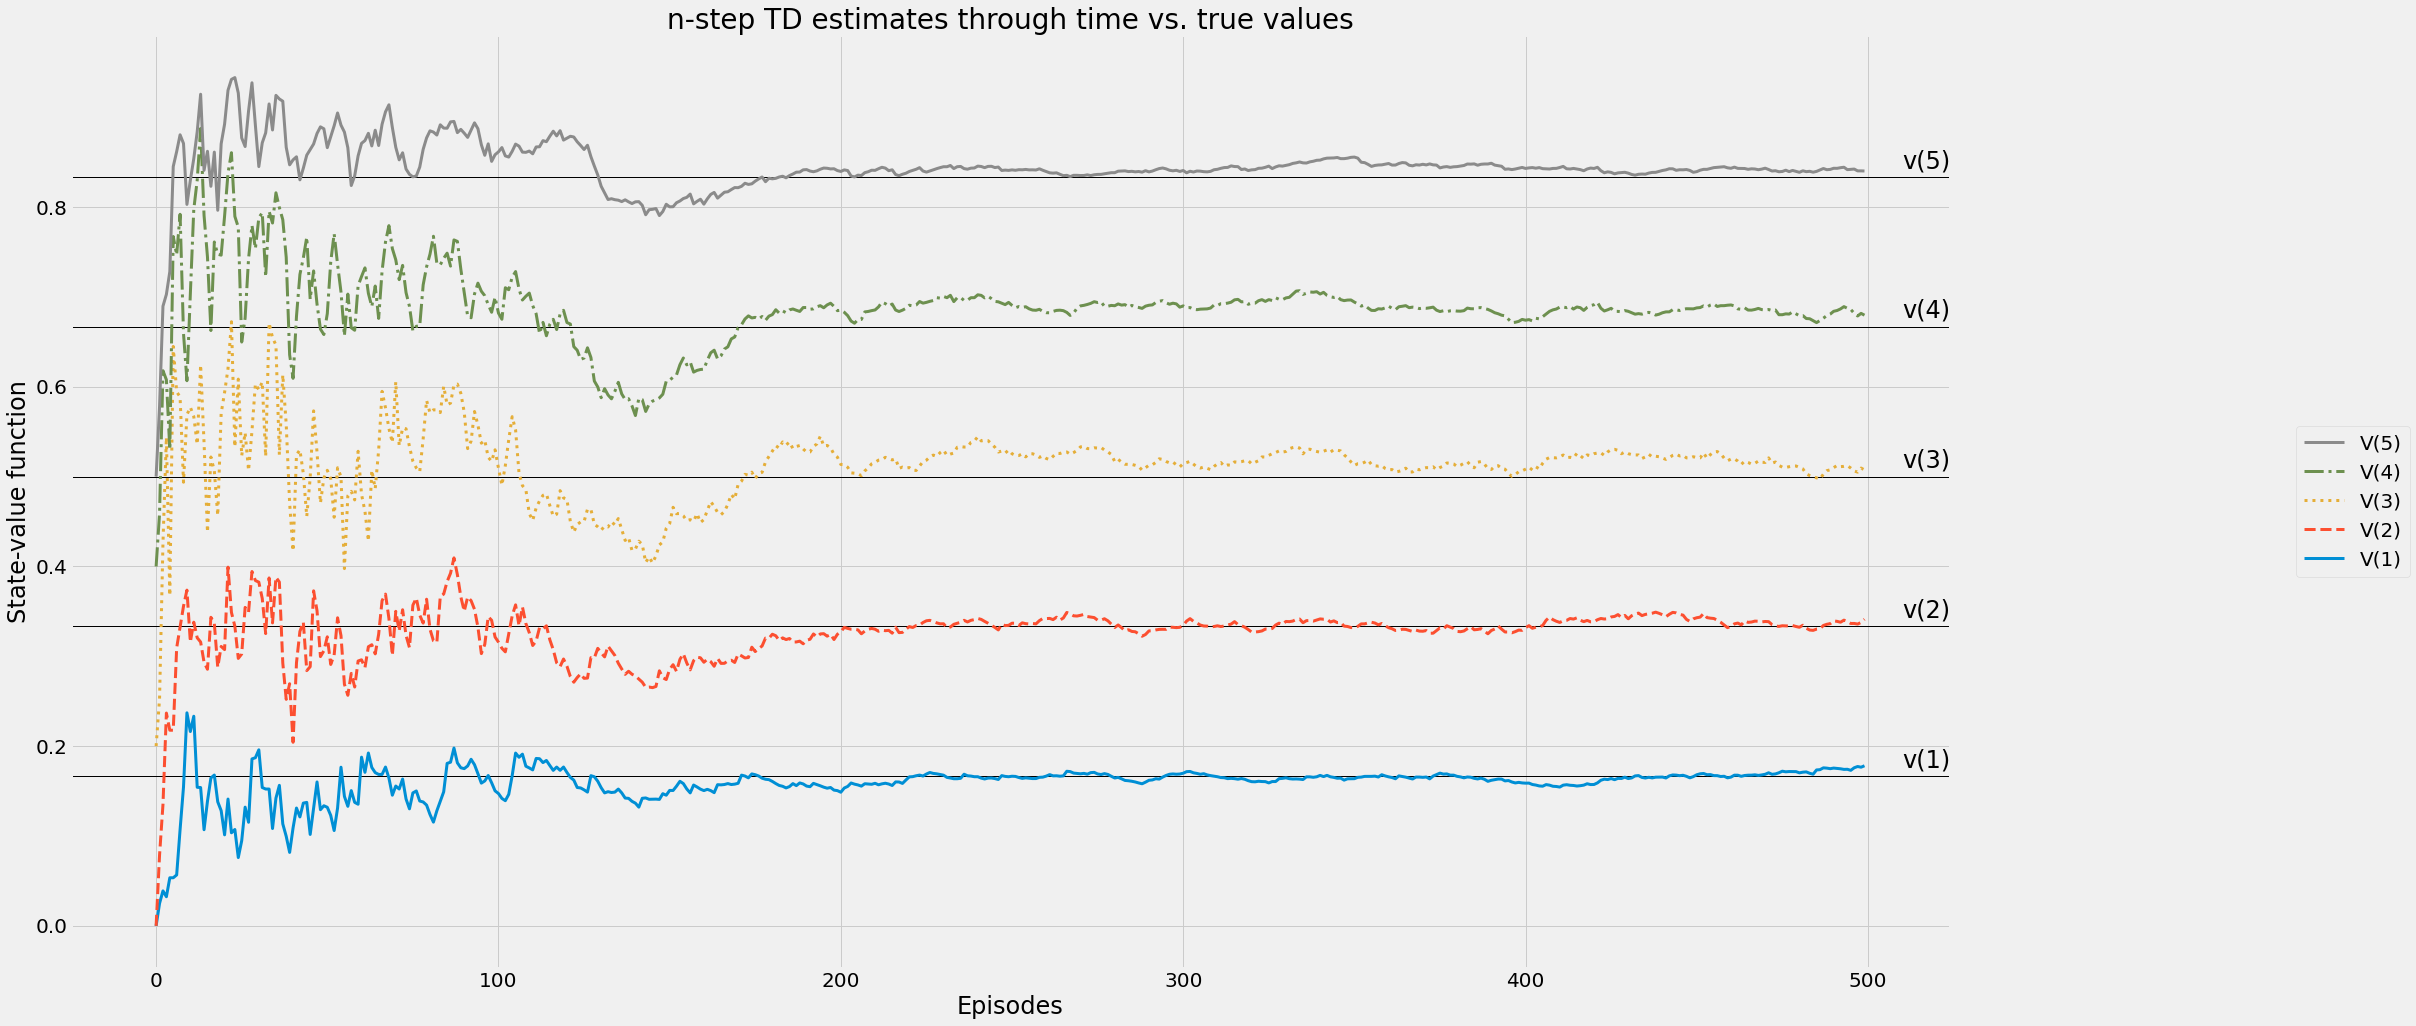

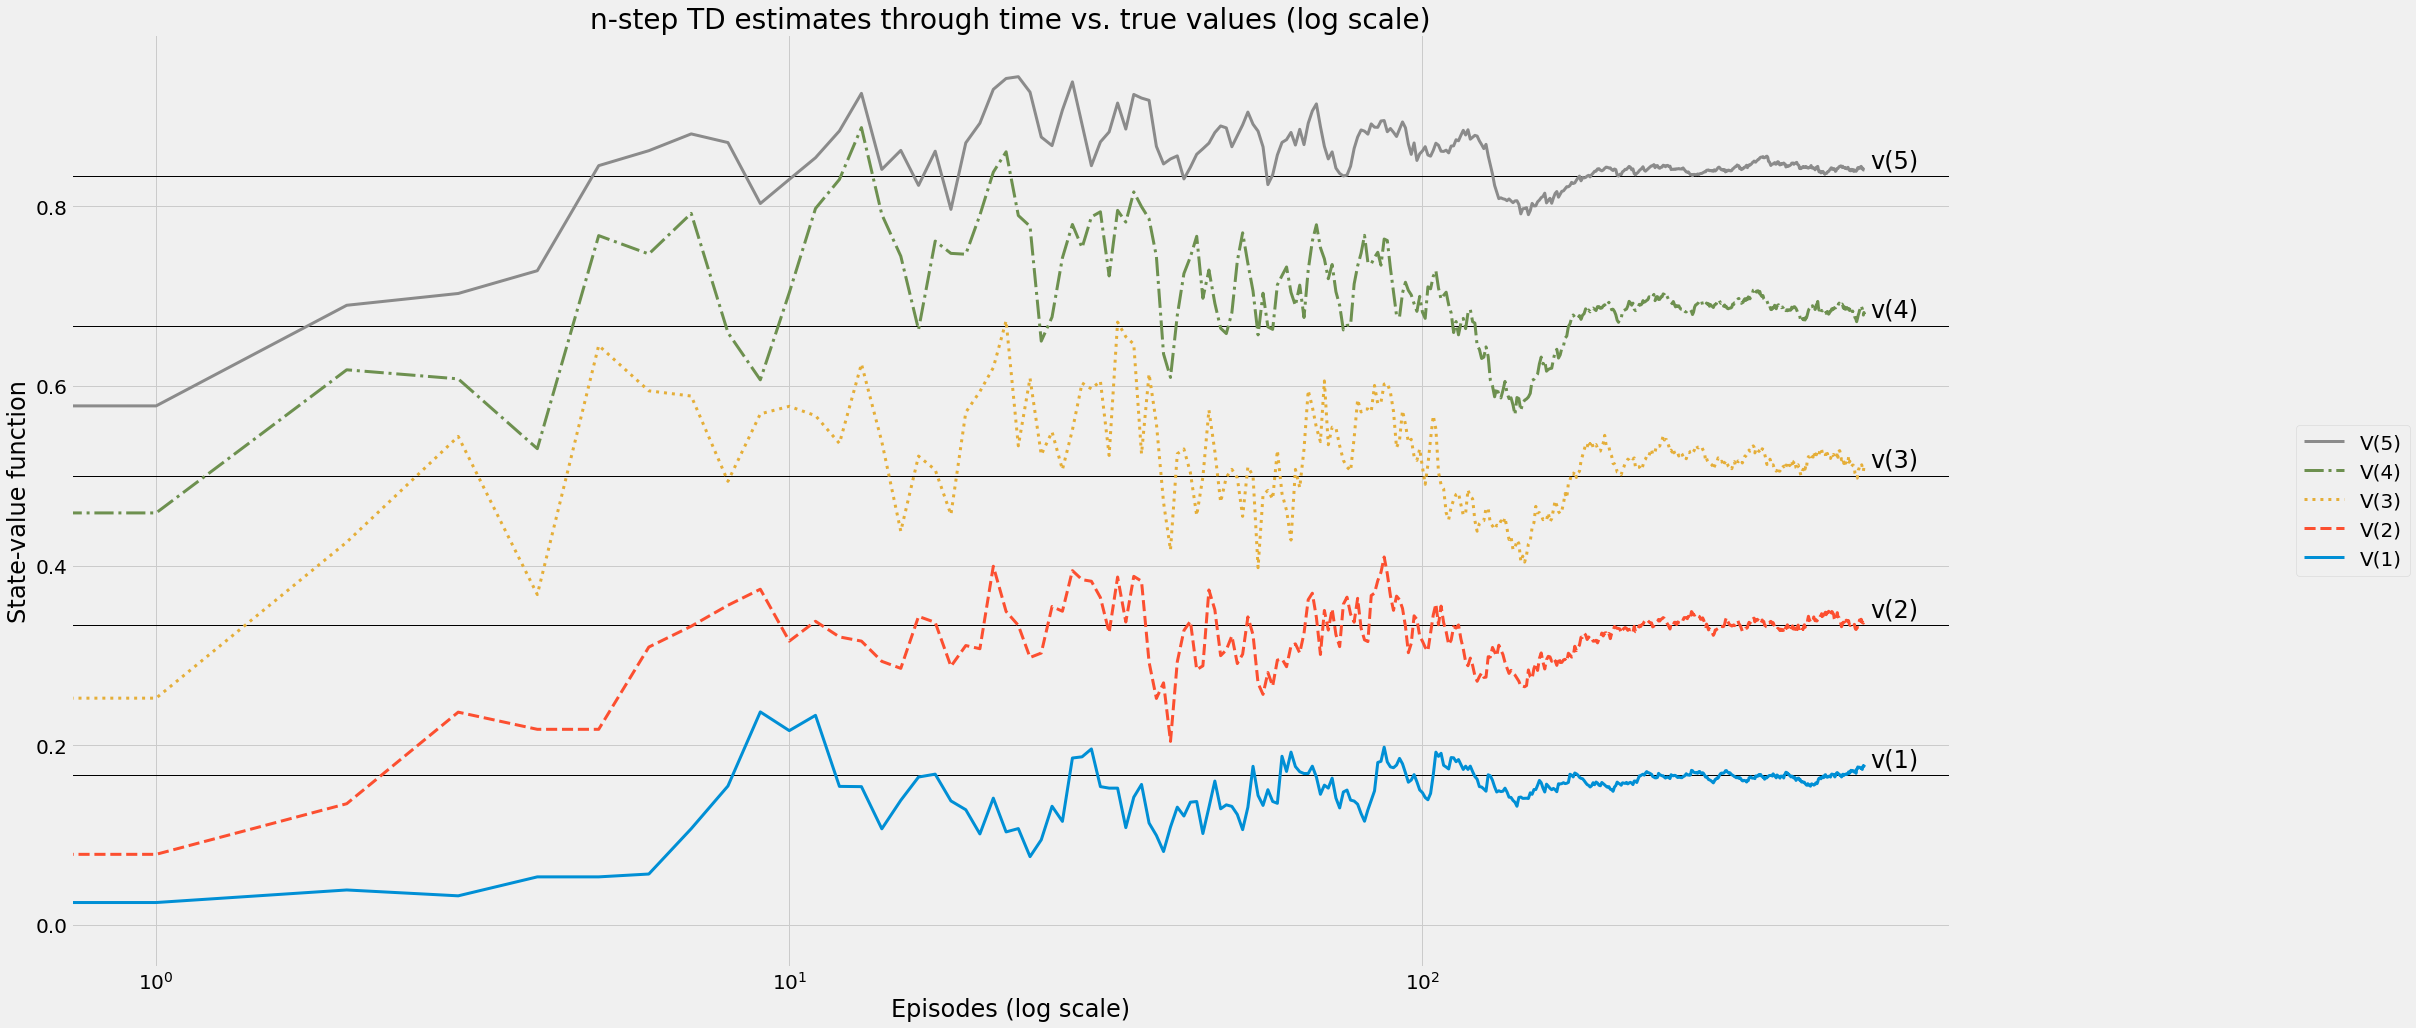

In [24]:
plot_value_function('n-step TD estimates through time vs. true values', V_track_ntd, V_true, log=False)
plot_value_function('n-step TD estimates through time vs. true values (log scale)', V_track_ntd, V_true, log=True)

## Forward-View Temporal-Difference learning

A prediction method that combines multiple n-steps into a single update


### Forward-view TD($\lambda$)

$$G_{t:T}^{\lambda} = \underbrace{(1-\lambda) \sum_{n=1}^{T-t-1} \lambda^{n-1} G_{t:t+n}}_{\text{1.}} + \underbrace{\lambda^{T-t-1} G_{t:T}}_{\text{2.}}$$

1. Sum of weighted returns from 1-step to $T-1$ steps
2. Weighted final return ($T$)

$$V_T(S_t) = V_{T-1}(S_t) + \alpha_t \Big[ \overbrace{\underbrace{G_{t:T}^{\lambda}}_{\lambda \text{-return}} - V_{T-1}(S_t)}^{\lambda \text{-error}} \Big]$$


### Backward-view TD($\lambda$)

$$\underbrace{\delta_{t:t+1}^{TD}(S_t)}_{\text{TD error}} = \underbrace{R_{t+1} + \gamma V_t(S_{t+1})}_{\text{TD target}} - V_t(S_t)$$

The entire estimated state-value funcition is updated every time step
$$V_{T+1} = V_T + \alpha_t \delta_{t:t+1}^{TD}(S_t)E_t$$


In [25]:
def td_lambda(pi,
                env,
                gamma=1.0,
                init_alpha=0.5,
                min_alpha=0.01,
                alpha_decay_ratio=0.5,
                lambda_=0.3,
                n_episodes=500):
    
    nS = env.observation_space.n
    V = np.zeros(nS)
    V_track = np.zeros((n_episodes, nS))

    # Elegibitity trace vector
    E = np.zeros(nS)

    alphas = decay_schedule(
        init_alpha, min_alpha,
        alpha_decay_ratio, n_episodes
    )


    for e in tqdm(range(n_episodes), leave=False):
        E.fill(0)
        state, done = env.reset(), False

        while not done:
            action = pi(state)
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * V[next_state] * (not done)

            td_error = td_target - V[state]
            E[state] = E[state] + 1
            V = V + alphas[e] * td_error * E
            E = gamma * lambda_ * E         # decay E
            state = next_state
        
        V_track[e] = V
    
    return V, V_track

In [26]:
%%capture
V_tdls, V_track_tdls = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_tdl, V_track_tdl = td_lambda(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tdls.append(V_tdl) ; V_track_tdls.append(V_track_tdl)
V_tdl, V_track_tdl = np.mean(V_tdls, axis=0), np.mean(V_track_tdls, axis=0)
del V_tdls ; del V_track_tdls

In [27]:
print_state_value_function(V_tdl, P, n_cols=7)
print()
print_state_value_function(V_tdl - V_true, P, n_cols=7, title='State-value function errors:')

State-value function:
|           | 01  0.176 | 02  0.335 | 03  0.504 | 04  0.681 | 05  0.842 |           |

State-value function errors:
|           | 01  0.009 | 02  0.002 | 03  0.004 | 04  0.014 | 05  0.008 |           |


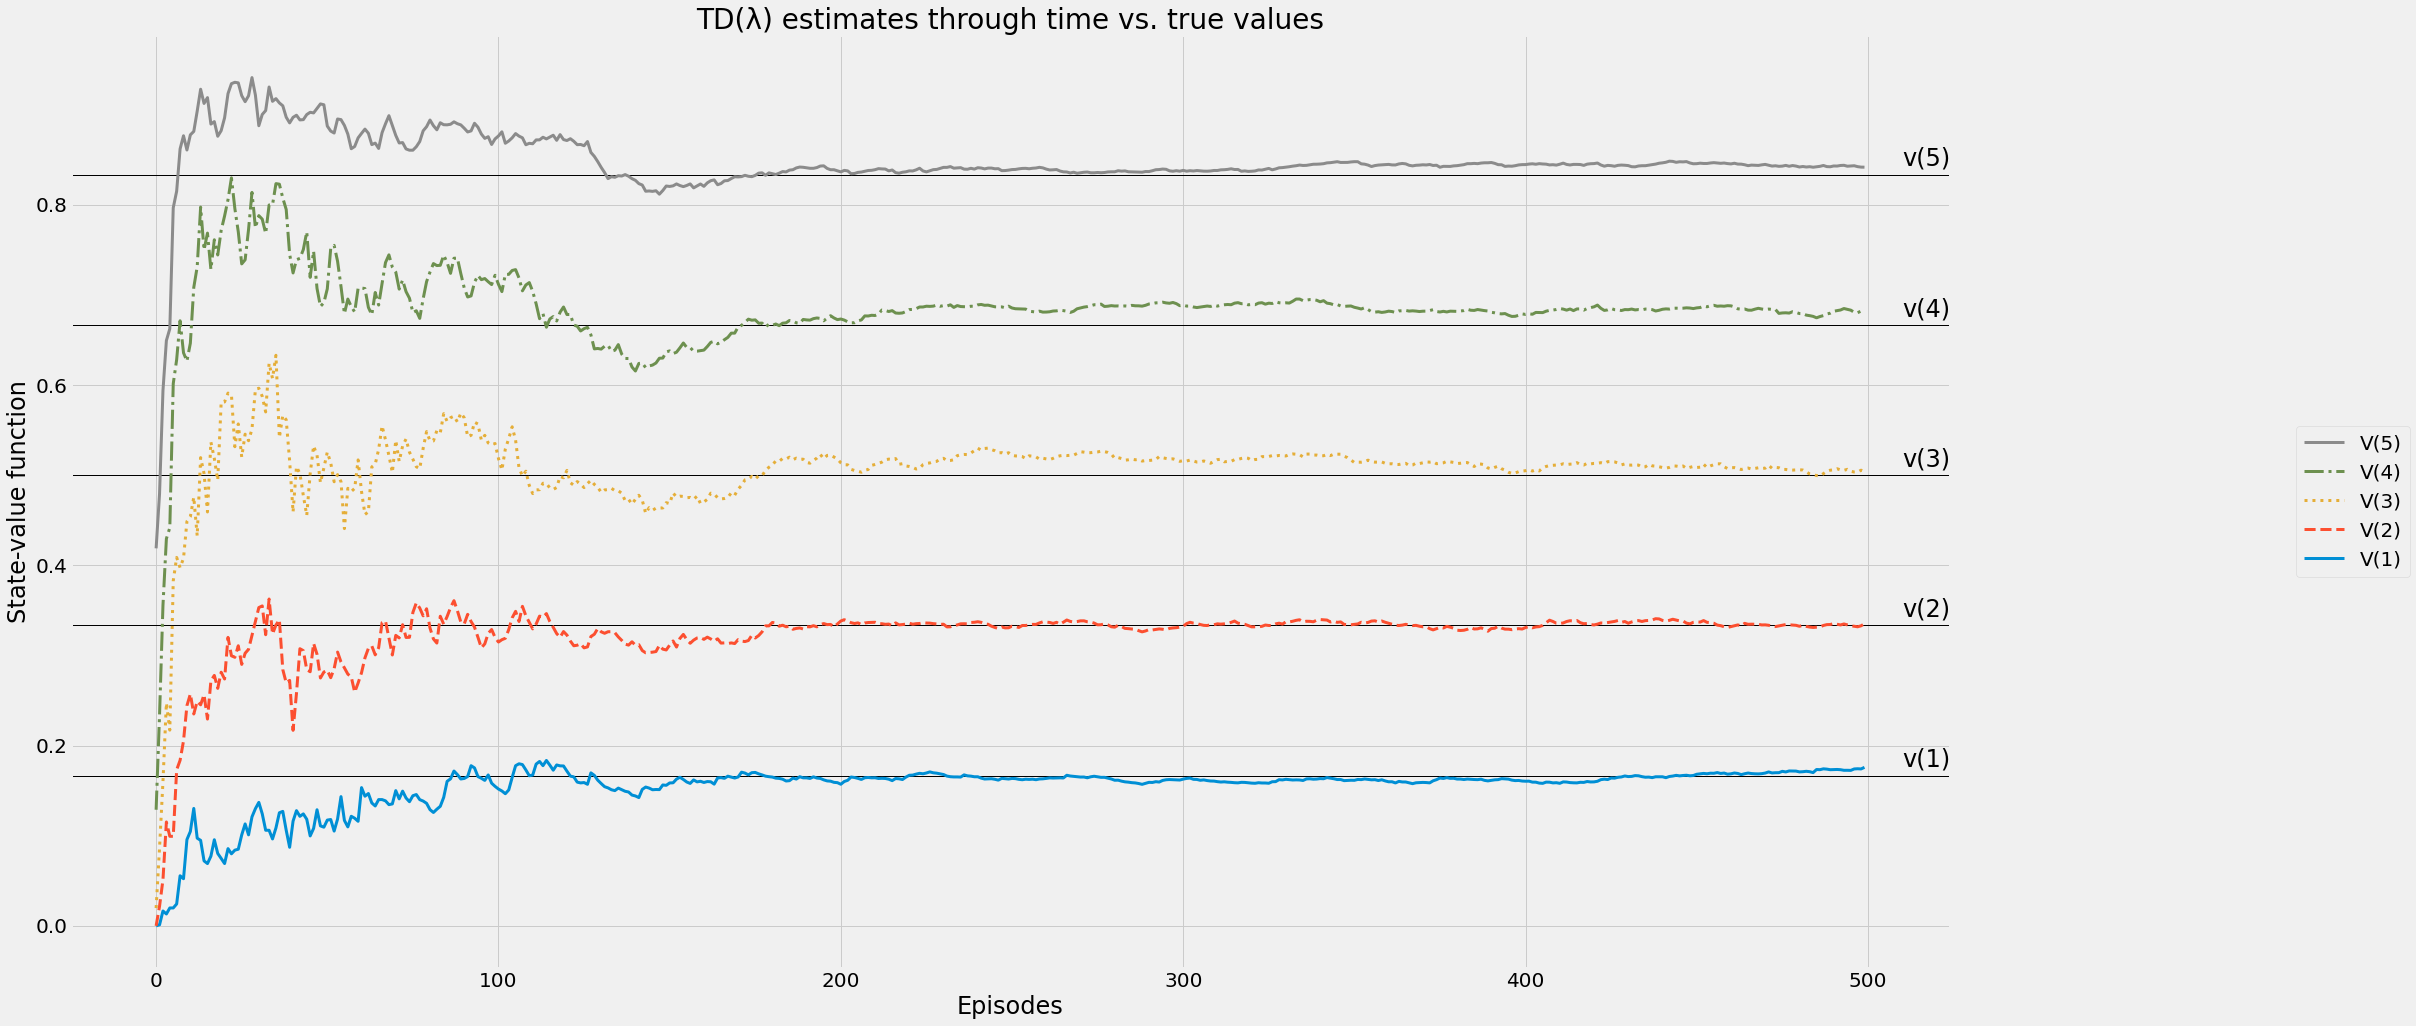

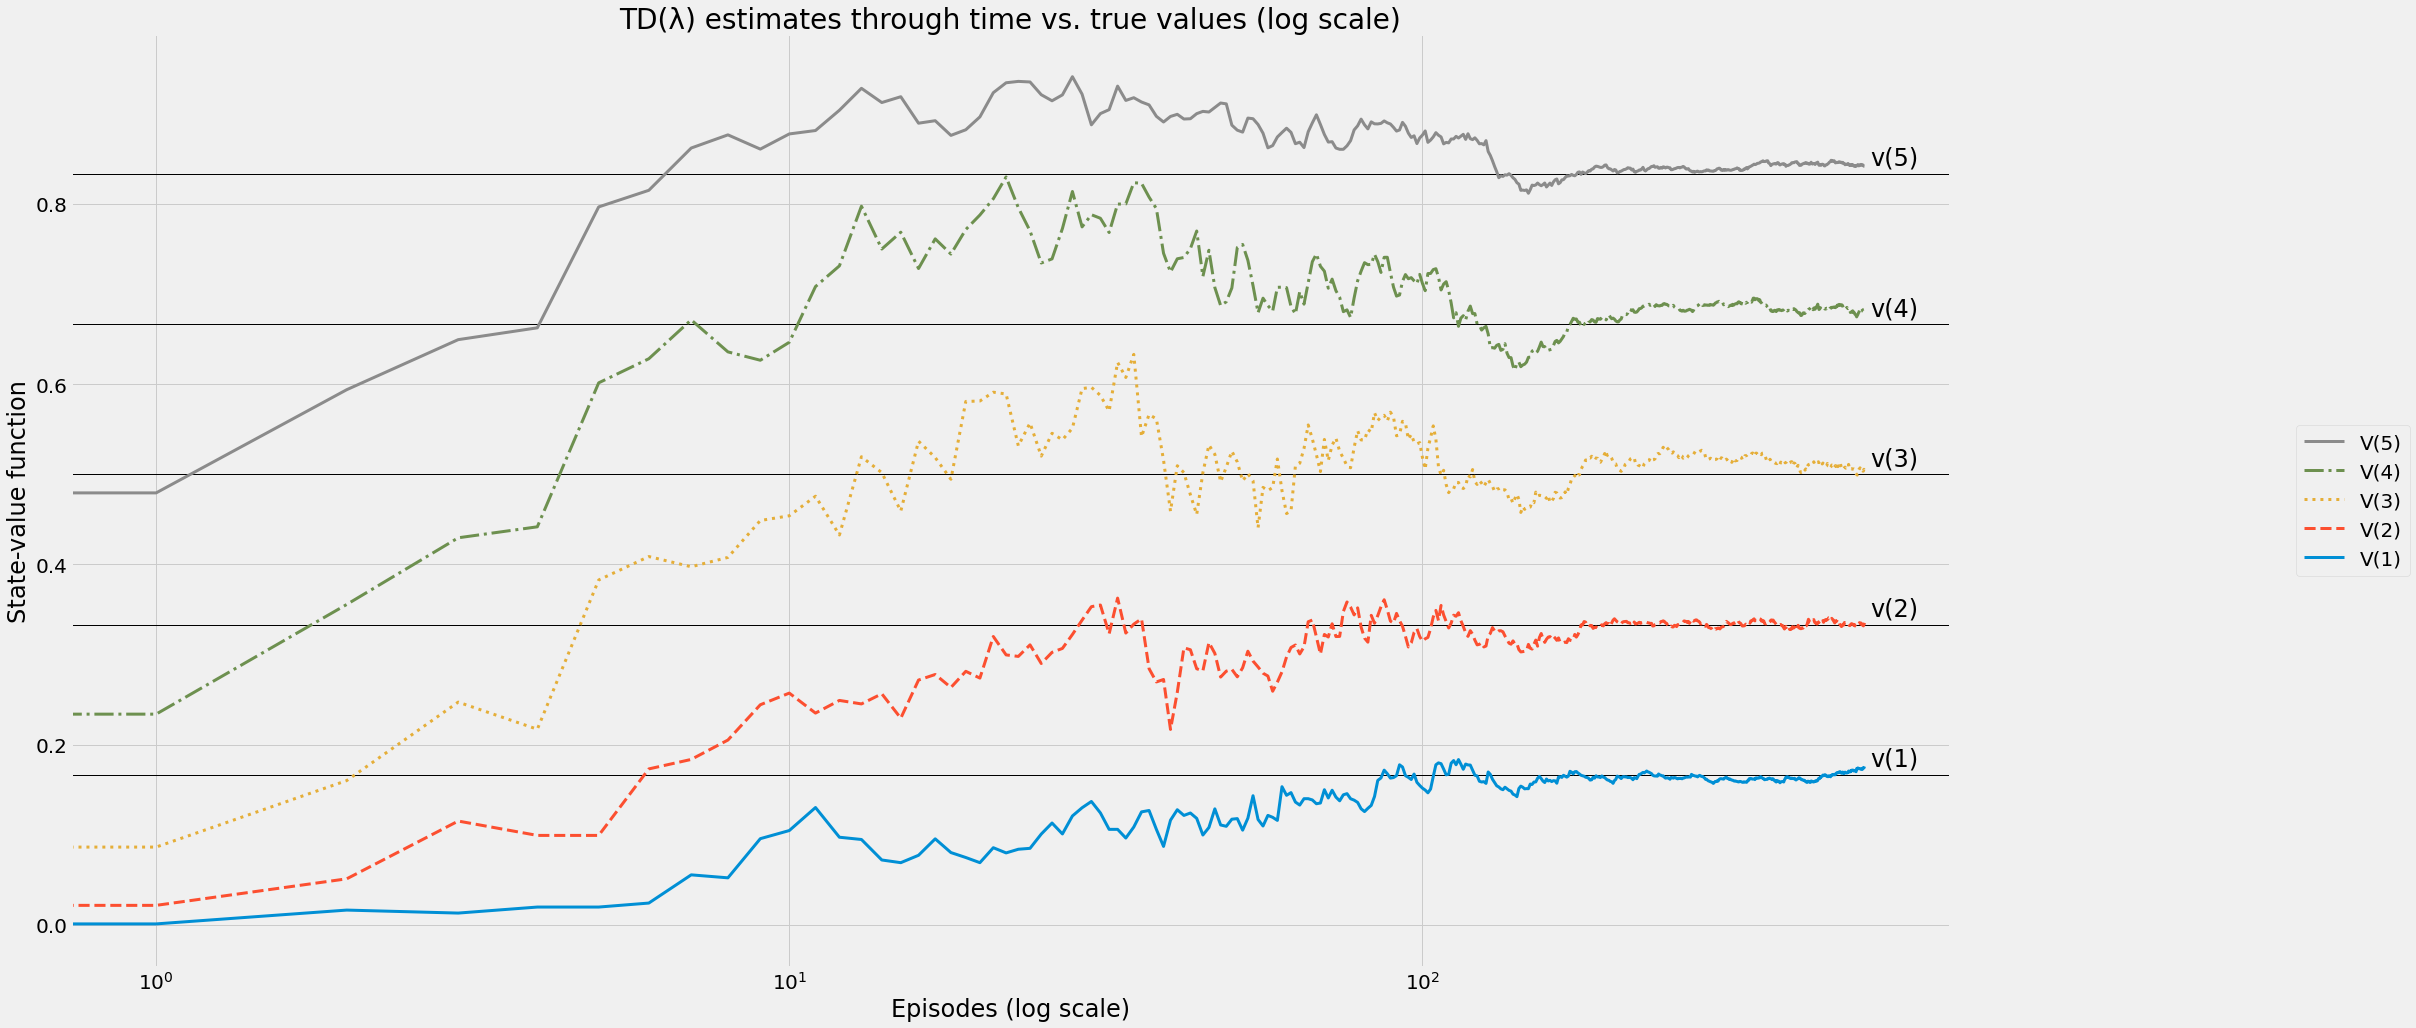

In [28]:
plot_value_function('TD(λ) estimates through time vs. true values', V_track_tdl, V_true, log=False)
plot_value_function('TD(λ) estimates through time vs. true values (log scale)', V_track_tdl, V_true, log=True)

## Russell & Norvig Gridworld

In [29]:
env = gym.make('RussellNorvigGridworld-v0')
init_state = env.reset()
goal_state = 3
gamma = 1.0
n_episodes = 1000
P = env.env.P


LEFT, DOWN, RIGHT, UP = range(4)
pi = lambda s: {
    0:RIGHT, 1:RIGHT, 2:RIGHT, 3:LEFT,
    4:UP,    5:LEFT,  6:UP,    7:LEFT,
    8:UP,    9:LEFT, 10:LEFT, 11:LEFT
}[s]
V_true = policy_evaluation(pi, P, gamma=gamma)

print_state_value_function(V_true, P)
print()

print_policy(pi, P)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}.'.format(
    probability_success(env, pi, goal_state=goal_state), 
    mean_return(env, gamma, pi)))

State-value function:
| 00  0.812 | 01  0.868 | 02  0.918 |           |
| 04  0.762 |           | 06   0.66 |           |
| 08  0.705 | 09  0.655 | 10  0.611 | 11  0.388 |

Policy:
| 00      > | 01      > | 02      > |           |
| 04      ^ |           | 06      ^ |           |
| 08      ^ | 09      < | 10      < | 11      < |
Reaches goal 96.00%. Obtains an average return of 0.6564.


### First-visit MC prediction

In [ ]:
V_fvmcs, V_track_fvmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_fvmc, V_track_fvmc, targets_fvmc = mc_prediction(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_fvmcs.append(V_fvmc) ; V_track_fvmcs.append(V_track_fvmc)
V_fvmc, V_track_fvmc = np.mean(V_fvmcs, axis=0), np.mean(V_track_fvmcs, axis=0)
del V_fvmcs ; del V_track_fvmcs

In [36]:
print_state_value_function(V_fvmc, P)
print()
print_state_value_function(V_fvmc - V_true, P, title='State-value function errors:')

State-value function:
| 00  0.816 | 01  0.872 | 02  0.923 |           |
| 04  0.767 |           | 06  0.686 |           |
| 08  0.712 | 09  0.642 | 10    0.0 | 11    0.0 |

State-value function errors:
| 00  0.005 | 01  0.004 | 02  0.005 |           |
| 04  0.005 |           | 06  0.026 |           |
| 08  0.007 | 09 -0.013 | 10 -0.611 | 11 -0.388 |


### Every-visit MC prediction

In [ ]:
V_evmcs, V_track_evmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_evmc, V_track_evmc, targets_evmc = mc_prediction(pi, env, gamma=gamma, n_episodes=n_episodes, first_visit=False)
    V_evmcs.append(V_evmc) ; V_track_evmcs.append(V_track_evmc)
V_evmc, V_track_evmc = np.mean(V_evmcs, axis=0), np.mean(V_track_evmcs, axis=0)
del V_evmcs ; del V_track_evmcs

In [38]:
print_state_value_function(V_evmc, P)
print()
print_state_value_function(V_evmc - V_true, P, title='State-value function errors:')

State-value function:
| 00  0.819 | 01  0.864 | 02  0.921 |           |
| 04  0.772 |           | 06  0.693 |           |
| 08  0.716 | 09  0.657 | 10    0.0 | 11    0.0 |

State-value function errors:
| 00  0.007 | 01 -0.004 | 02  0.003 |           |
| 04  0.011 |           | 06  0.033 |           |
| 08   0.01 | 09  0.001 | 10 -0.611 | 11 -0.388 |


### TD prediction

In [ ]:
V_tds, V_track_tds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_td, V_track_td, targets_td = td(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tds.append(V_td) ; V_track_tds.append(V_track_td)
V_td, V_track_td = np.mean(V_tds, axis=0), np.mean(V_track_tds, axis=0)
del V_tds ; del V_track_tds

In [42]:
print_state_value_function(V_td, P)
print()
print_state_value_function(V_td - V_true, P, title='State-value function errors:')

State-value function:
| 00  0.802 | 01   0.86 | 02  0.915 |           |
| 04  0.752 |           | 06  0.652 |           |
| 08  0.692 | 09  0.592 | 10    0.0 | 11    0.0 |

State-value function errors:
| 00 -0.009 | 01 -0.008 | 02 -0.003 |           |
| 04 -0.009 |           | 06 -0.008 |           |
| 08 -0.014 | 09 -0.063 | 10 -0.611 | 11 -0.388 |


### n-TD prediction

In [ ]:
V_ntds, V_track_ntds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_ntd, V_track_ntd = ntd(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_ntds.append(V_ntd) ; V_track_ntds.append(V_track_ntd)
V_ntd, V_track_ntd = np.mean(V_ntds, axis=0), np.mean(V_track_ntds, axis=0)
del V_ntds ; del V_track_ntds

In [40]:
print_state_value_function(V_ntd, P)
print()
print_state_value_function(V_ntd - V_true, P, title='State-value function errors:')

State-value function:
| 00  0.818 | 01  0.874 | 02  0.923 |           |
| 04  0.769 |           | 06  0.727 |           |
| 08  0.715 | 09  0.659 | 10    0.0 | 11    0.0 |

State-value function errors:
| 00  0.006 | 01  0.006 | 02  0.005 |           |
| 04  0.007 |           | 06  0.067 |           |
| 08   0.01 | 09  0.003 | 10 -0.611 | 11 -0.388 |


### TD($\lambda$) prediction

In [ ]:
V_tdls, V_track_tdls = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.seed(seed)
    V_tdl, V_track_tdl = td_lambda(pi, env, gamma=gamma, n_episodes=n_episodes)
    V_tdls.append(V_tdl) ; V_track_tdls.append(V_track_tdl)
V_tdl, V_track_tdl = np.mean(V_tdls, axis=0), np.mean(V_track_tdls, axis=0)
del V_tdls ; del V_track_tdls

In [44]:
print_state_value_function(V_tdl, P)
print()
print_state_value_function(V_tdl - V_true, P, title='State-value function errors:')

State-value function:
| 00  0.814 | 01   0.87 | 02  0.923 |           |
| 04  0.765 |           | 06  0.709 |           |
| 08  0.709 | 09  0.647 | 10    0.0 | 11    0.0 |

State-value function errors:
| 00  0.003 | 01  0.003 | 02  0.005 |           |
| 04  0.003 |           | 06  0.049 |           |
| 08  0.003 | 09 -0.008 | 10 -0.611 | 11 -0.388 |


### Results

In [53]:
V_track_fvmc

1507.40s - Error inserting pydevd breaks.
Traceback (most recent call last):
  File "c:\Users\danie\anaconda3\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_frame_eval\pydevd_modify_bytecode.py", line 328, in insert_pydevd_breaks
    for new_instruction in get_instructions_to_add(
  File "c:\Users\danie\anaconda3\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_frame_eval\pydevd_modify_bytecode.py", line 102, in get_instructions_to_add
    Instr("LOAD_CONST", _pydev_stop_at_break, lineno=stop_at_line - 1),
  File "c:\Users\danie\anaconda3\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_frame_eval\vendored\bytecode\instr.py", line 171, in __init__
    self._set(name, arg, lineno)
  File "c:\Users\danie\anaconda3\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_frame_eval\vendored\bytecode\instr.py", line 239, in _set
    _check_lineno(lineno)
  File "c:\Users\danie\anaconda3\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_frame_eval\vendored\bytecode\instr.py", line 74, in

array([[0.44      , 0.46      , 0.48      , ..., 0.072     , 0.        ,
        0.        ],
       [0.62909513, 0.68652021, 0.71636891, ..., 0.10351586, 0.        ,
        0.        ],
       [0.71198162, 0.788115  , 0.82288694, ..., 0.10351586, 0.        ,
        0.        ],
       ...,
       [0.81608611, 0.87179766, 0.92244348, ..., 0.64187793, 0.        ,
        0.        ],
       [0.81640525, 0.87195968, 0.92257904, ..., 0.64187793, 0.        ,
        0.        ],
       [0.8164012 , 0.87212009, 0.92279325, ..., 0.64205508, 0.        ,
        0.        ]])

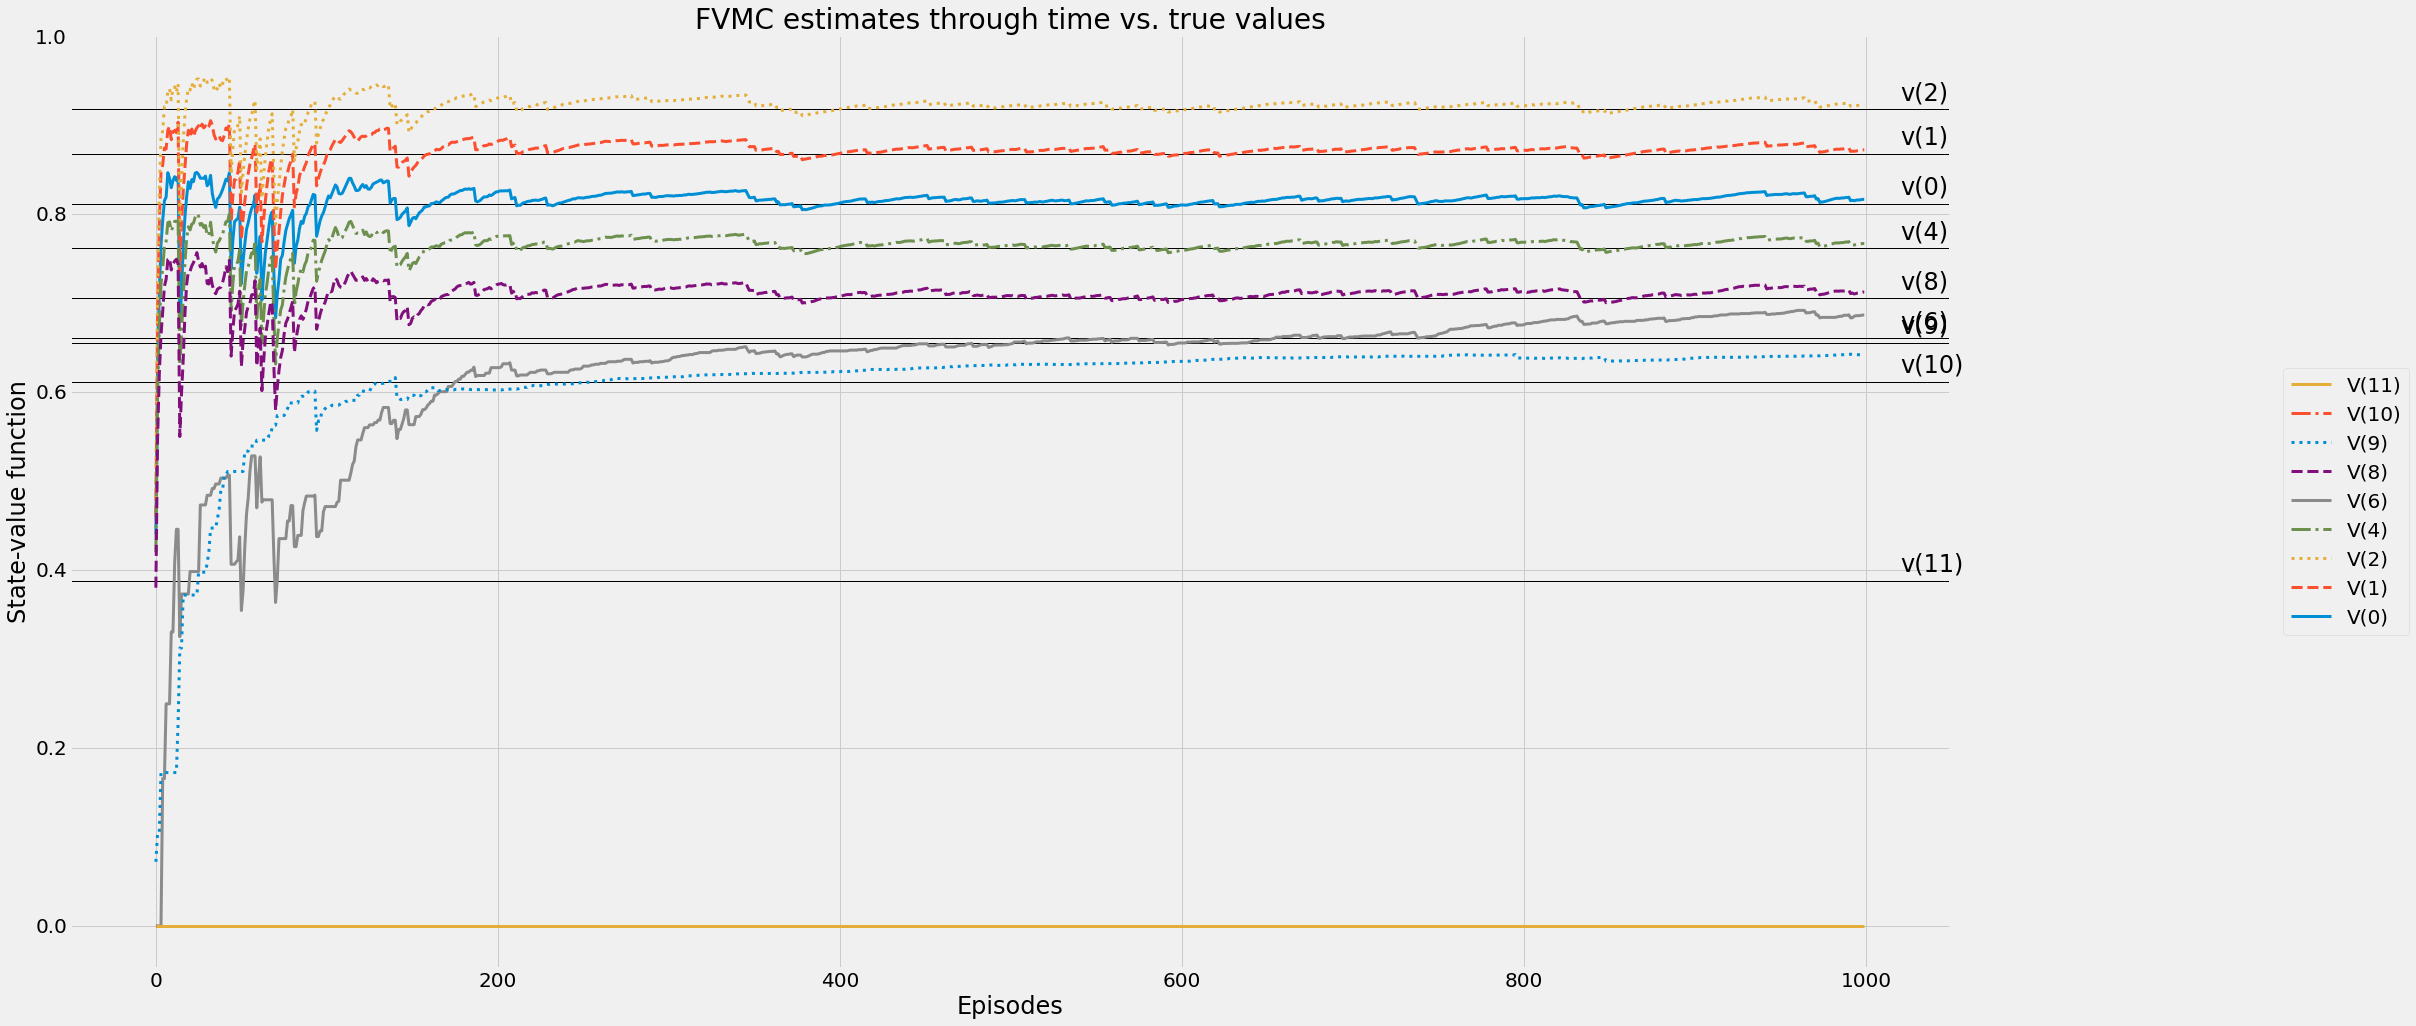

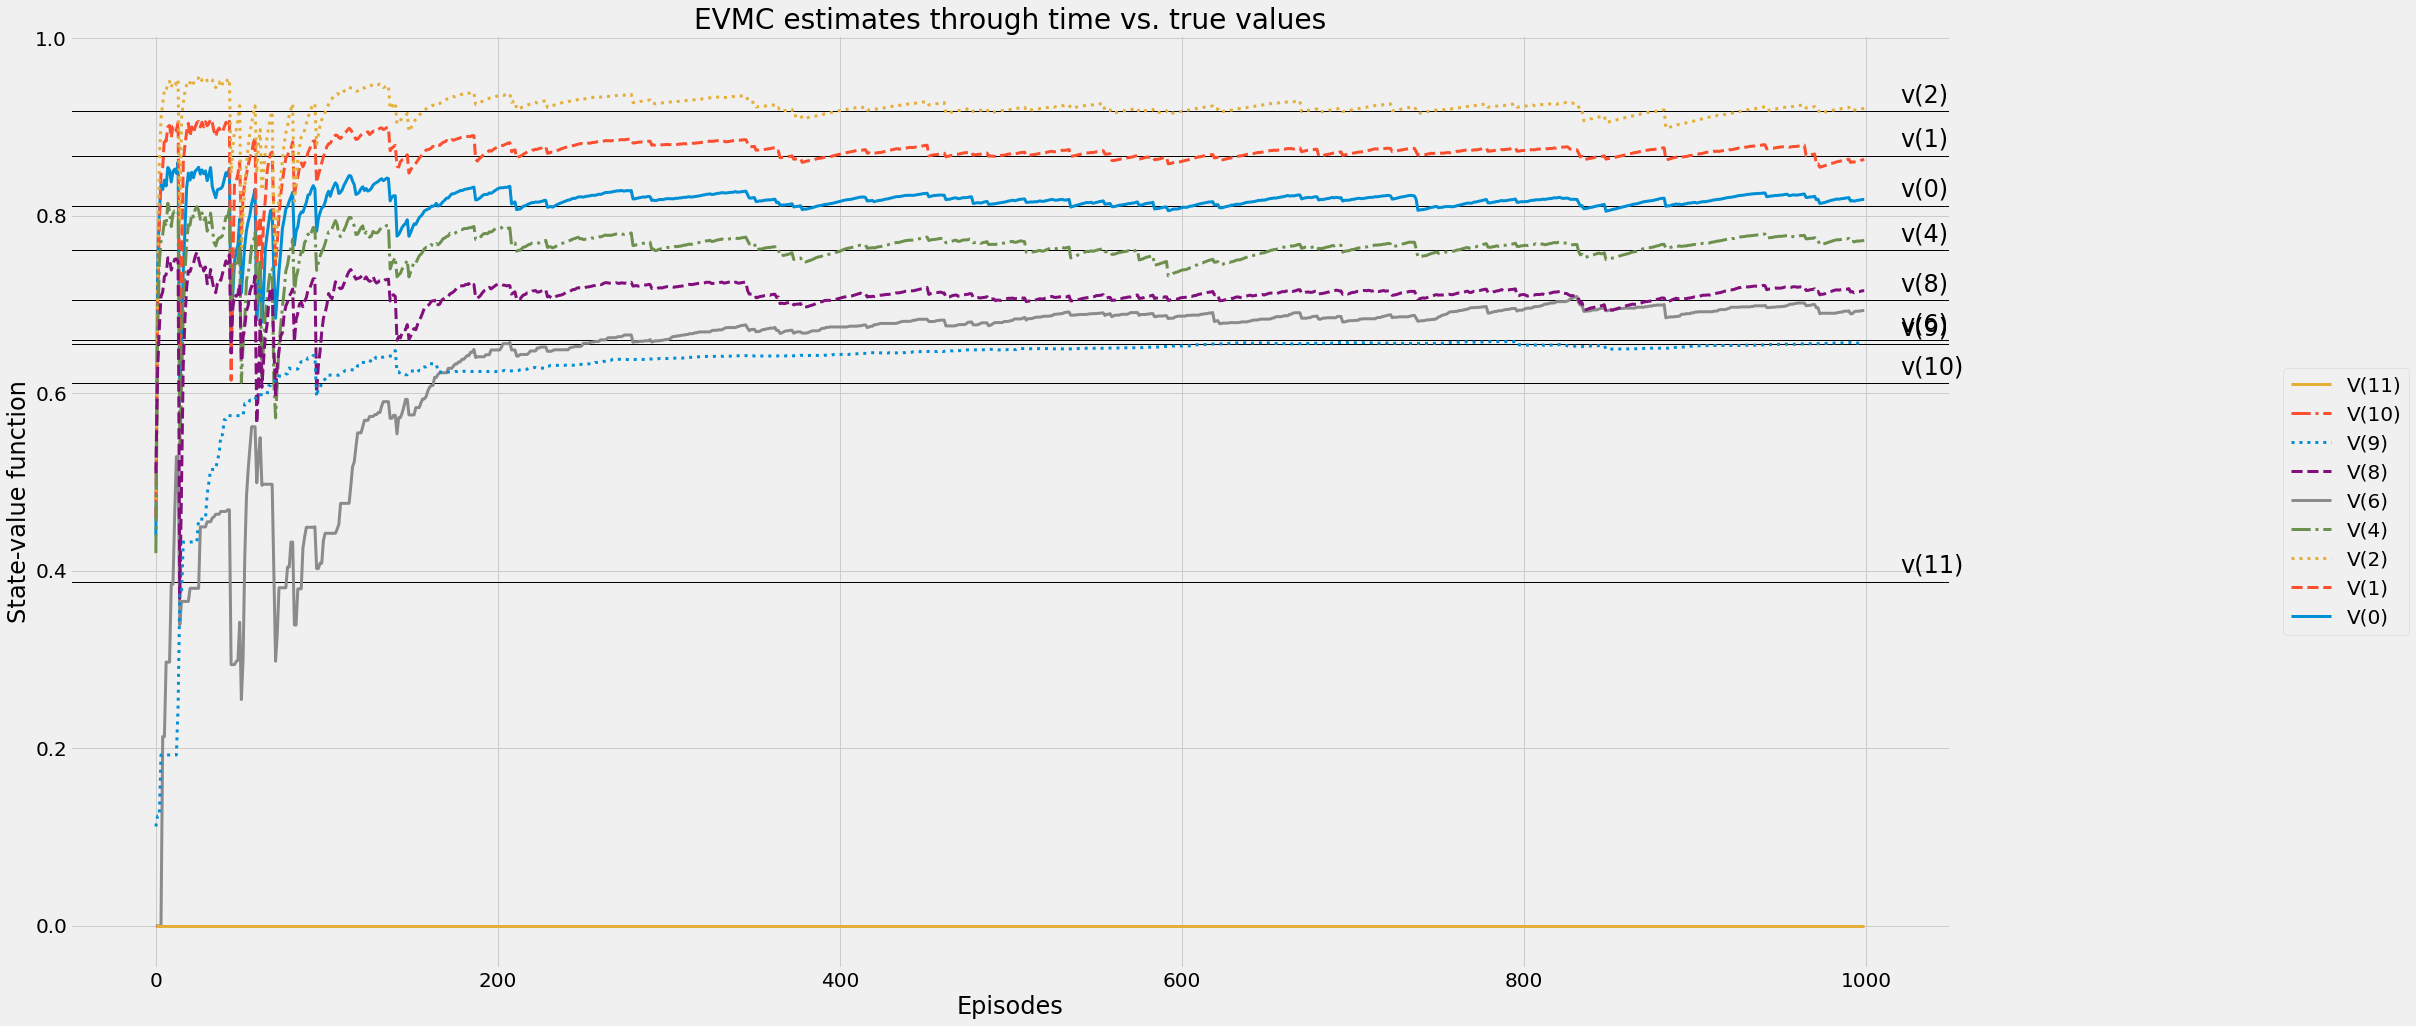

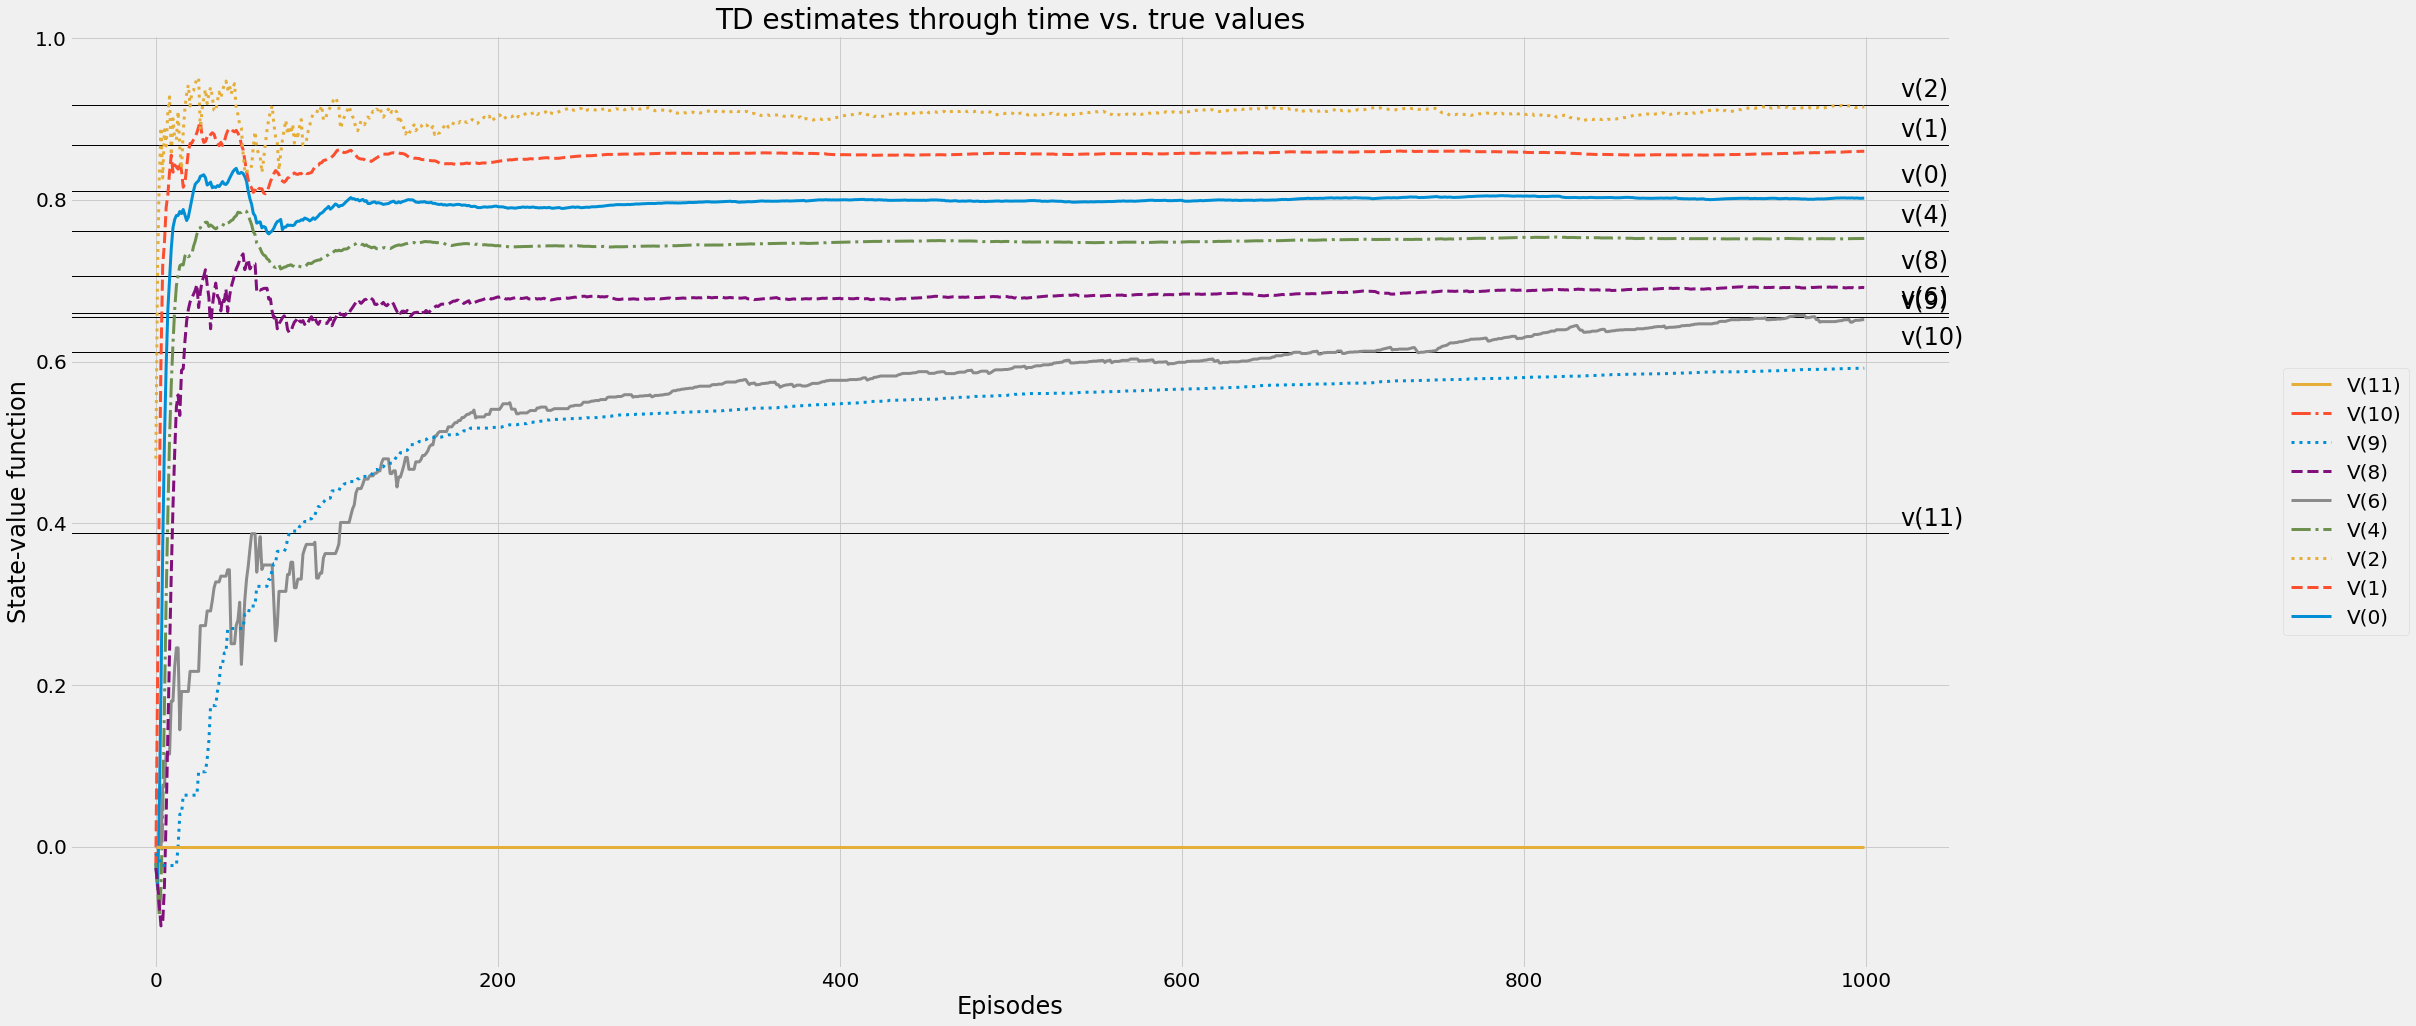

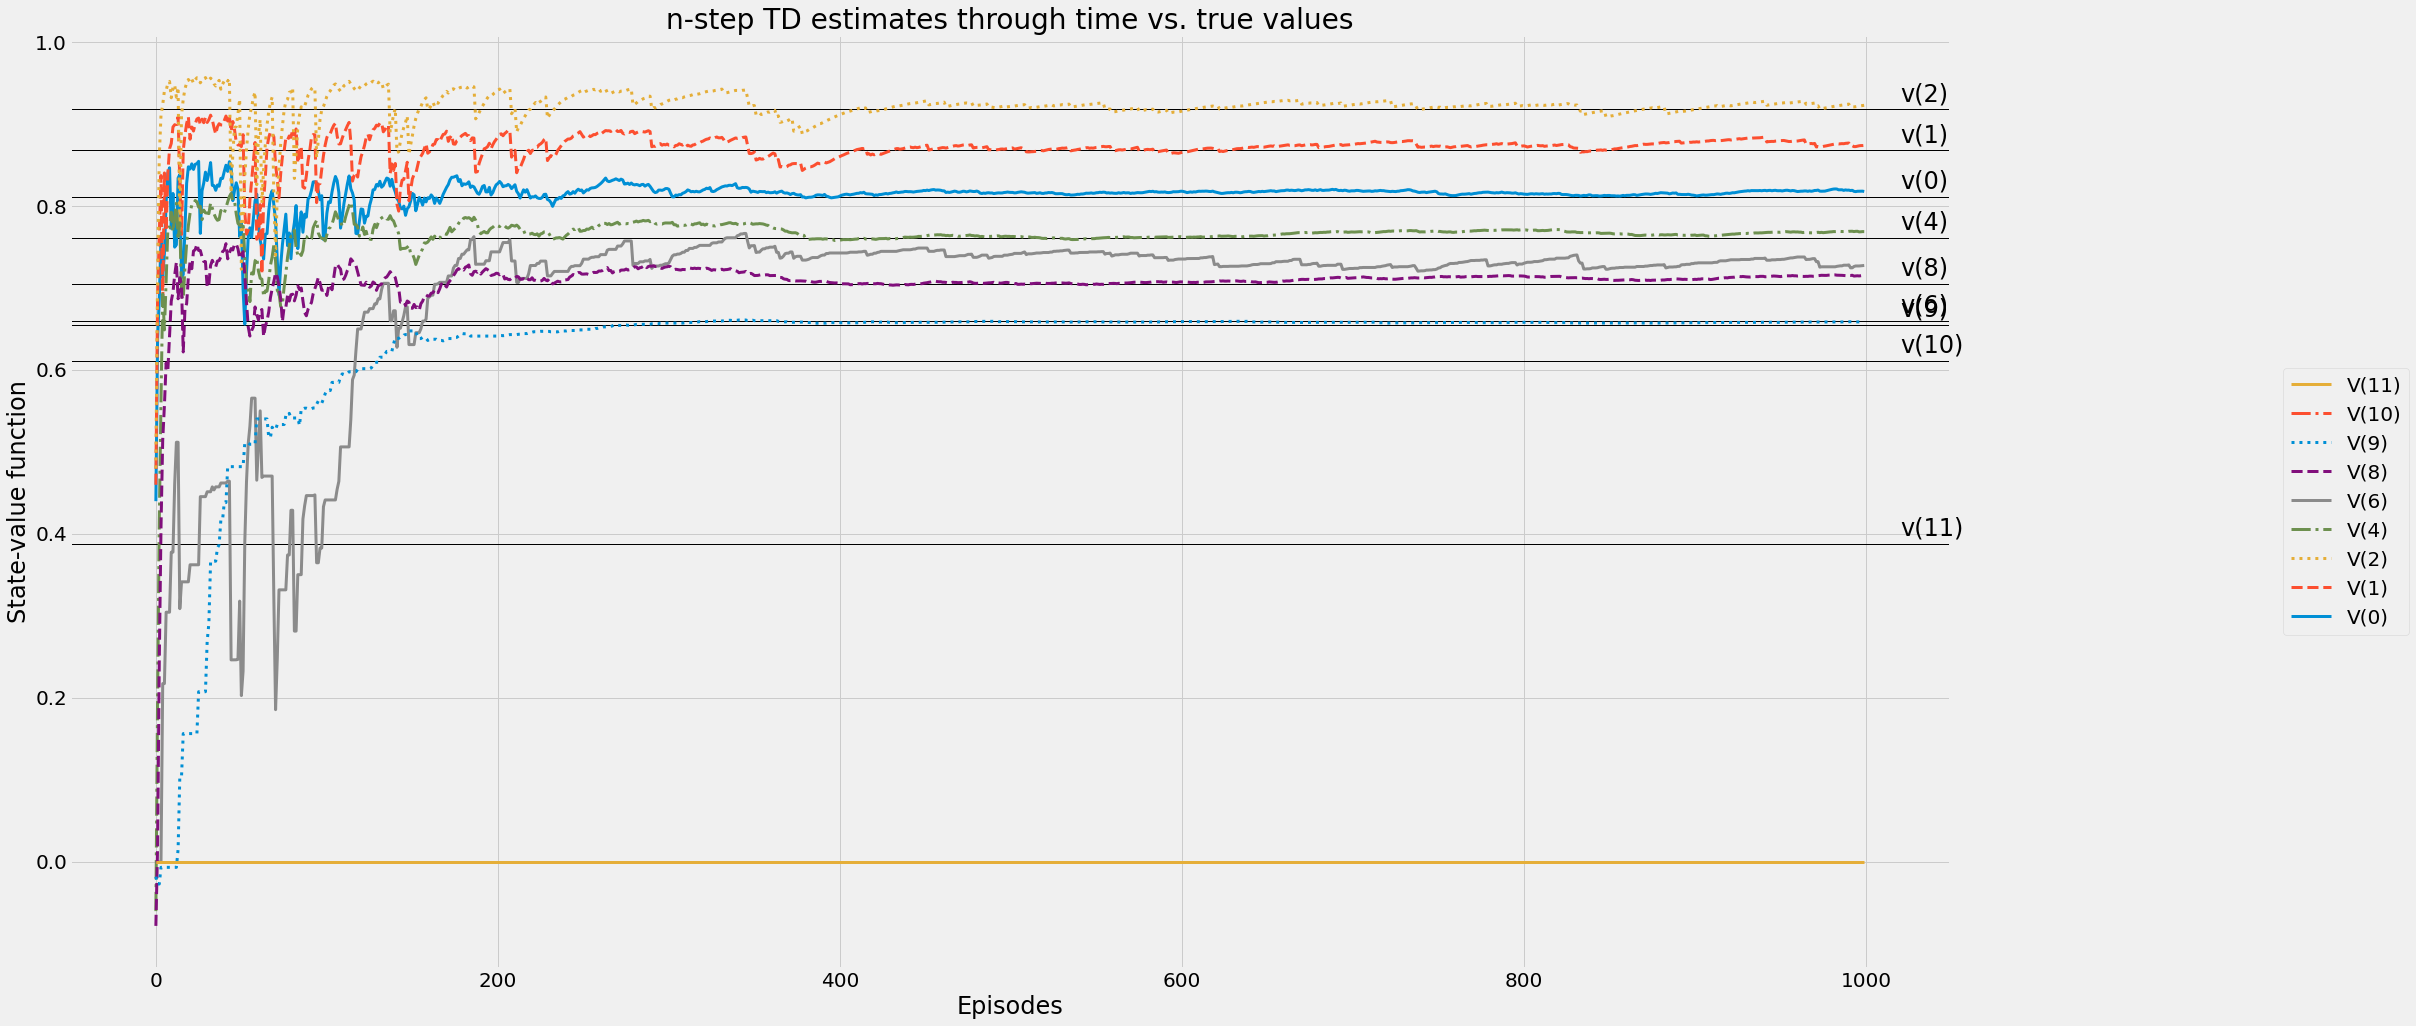

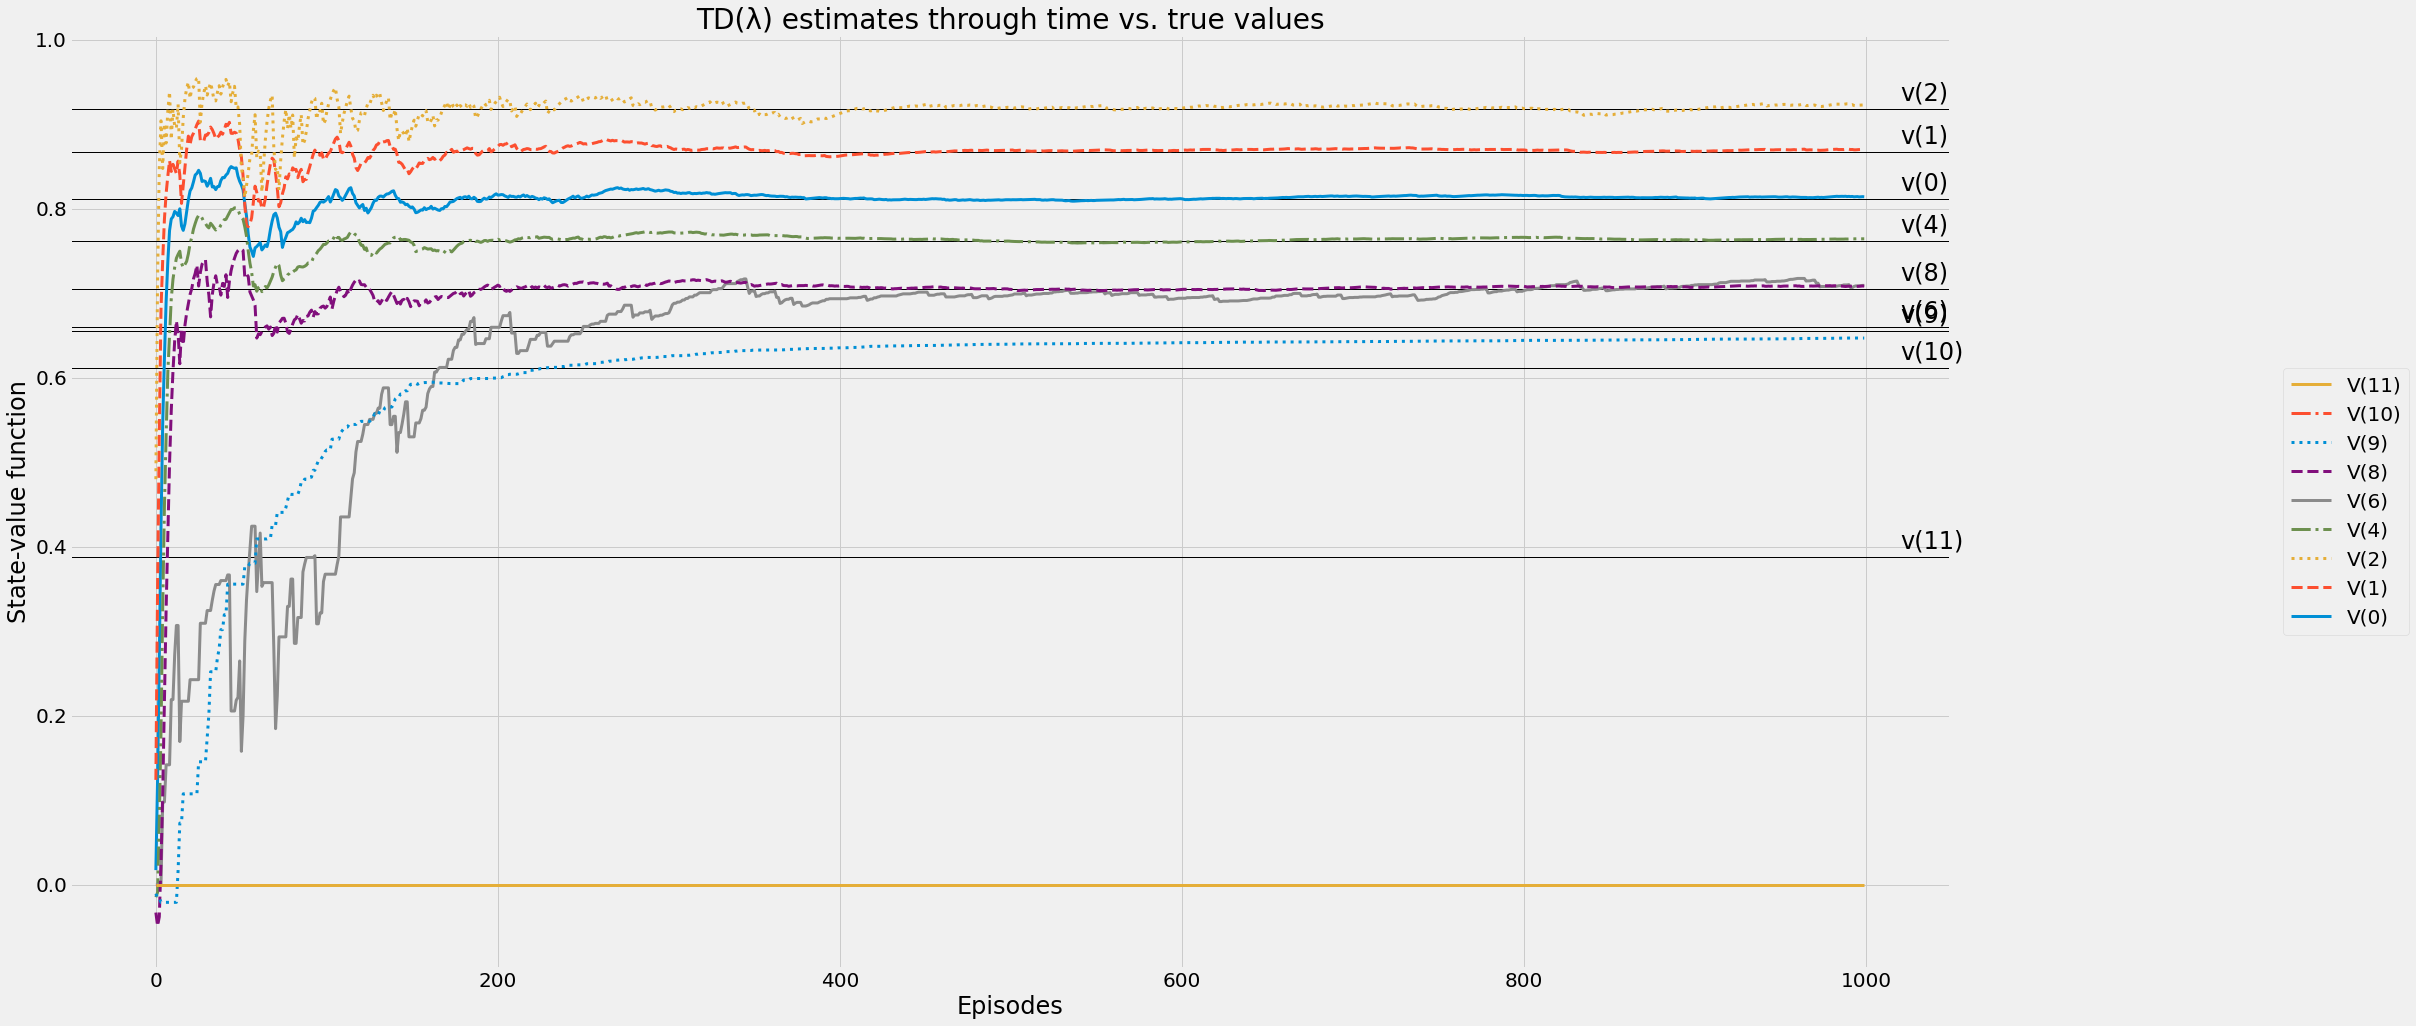

In [83]:
plot_value_function('FVMC estimates through time vs. true values', V_track_fvmc, V_true, log=False, limit_items=10)
plot_value_function('EVMC estimates through time vs. true values', V_track_evmc, V_true, log=False, limit_items=10)
plot_value_function('TD estimates through time vs. true values', V_track_td, V_true, log=False, limit_items=10)
plot_value_function('n-step TD estimates through time vs. true values', V_track_ntd, V_true, log=False, limit_items=10)
plot_value_function('TD(λ) estimates through time vs. true values', V_track_tdl, V_true, log=False, limit_items=10)

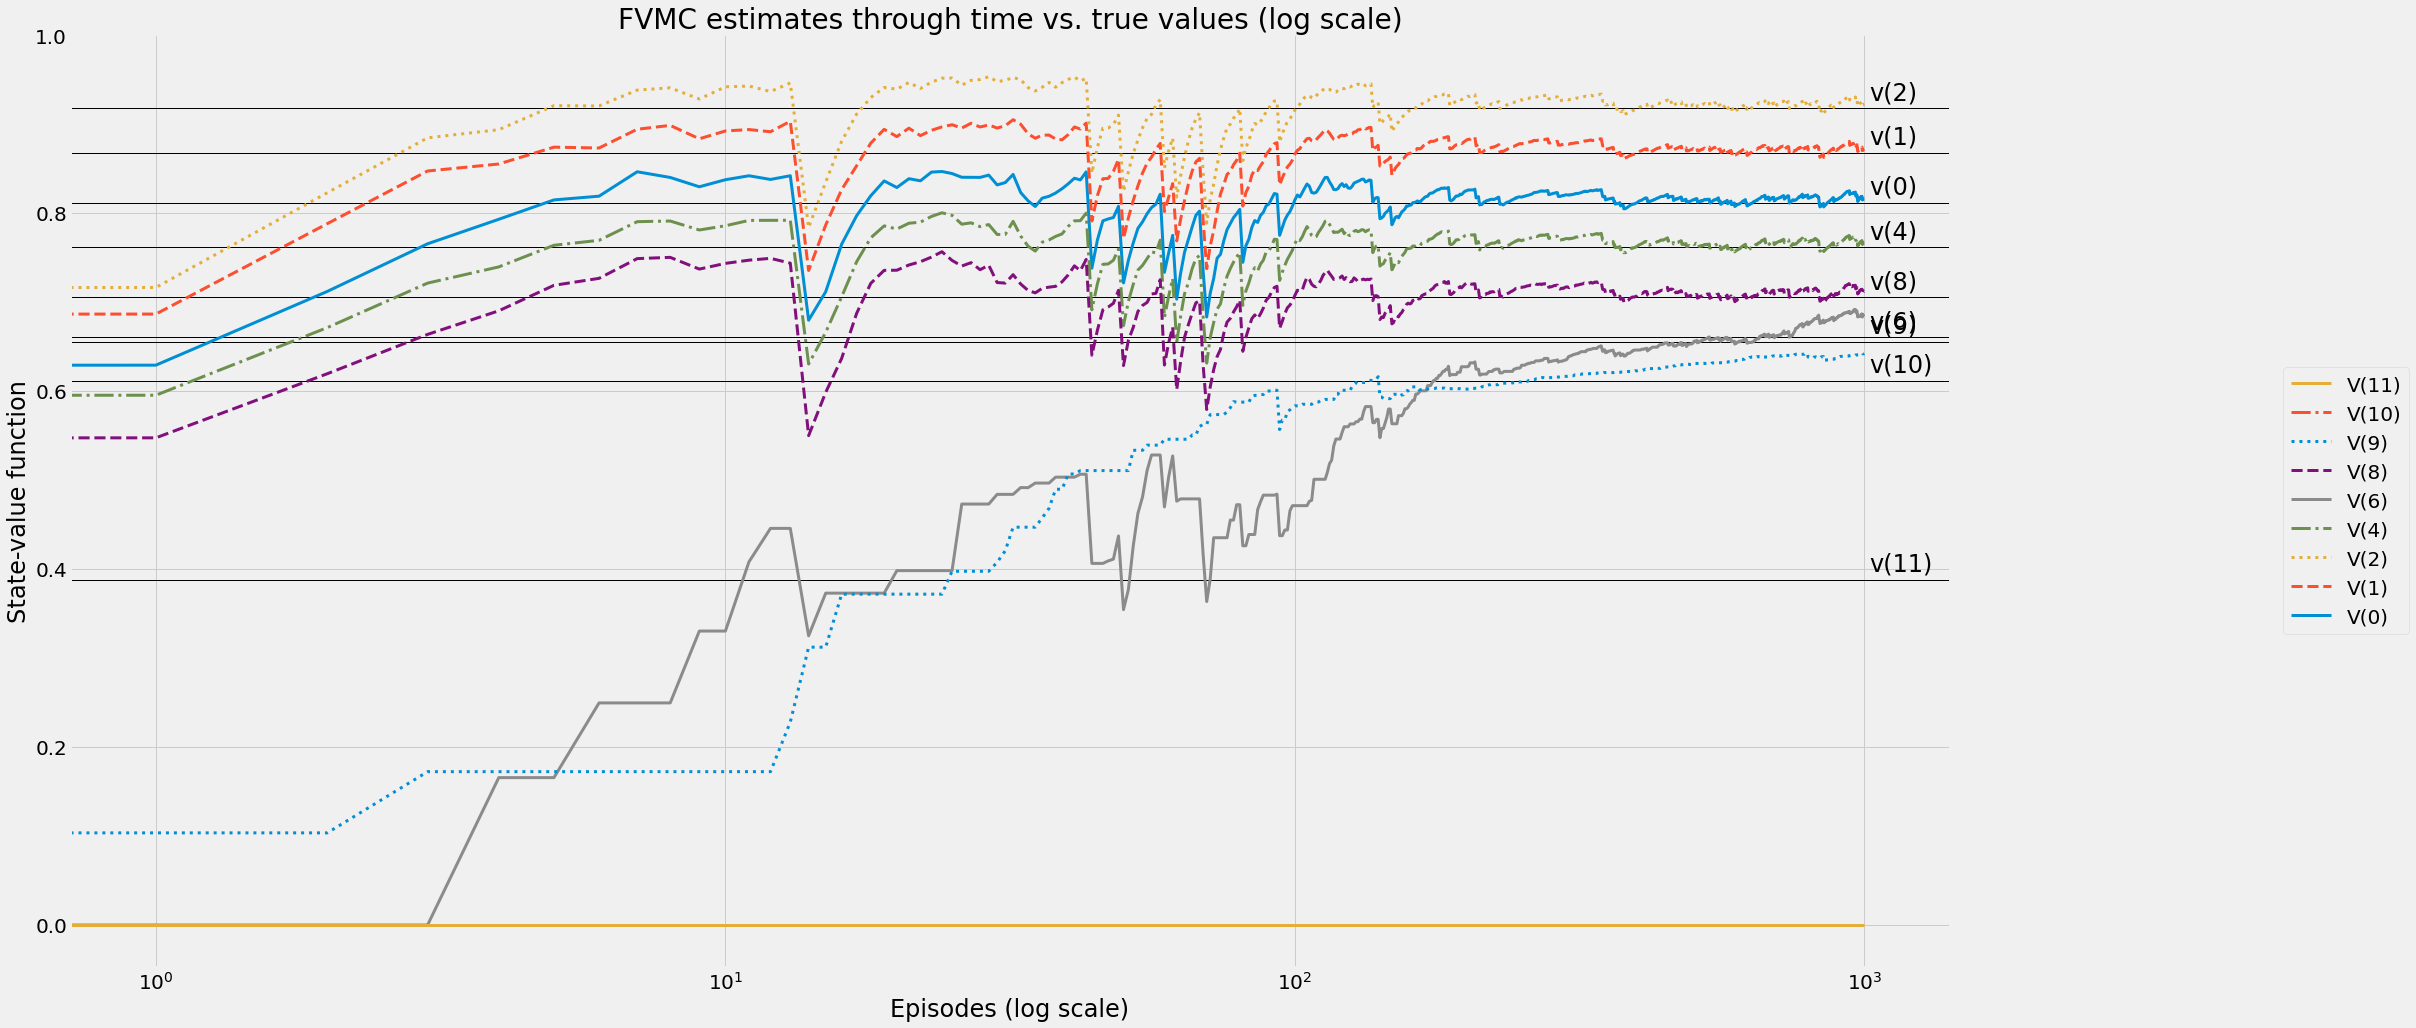

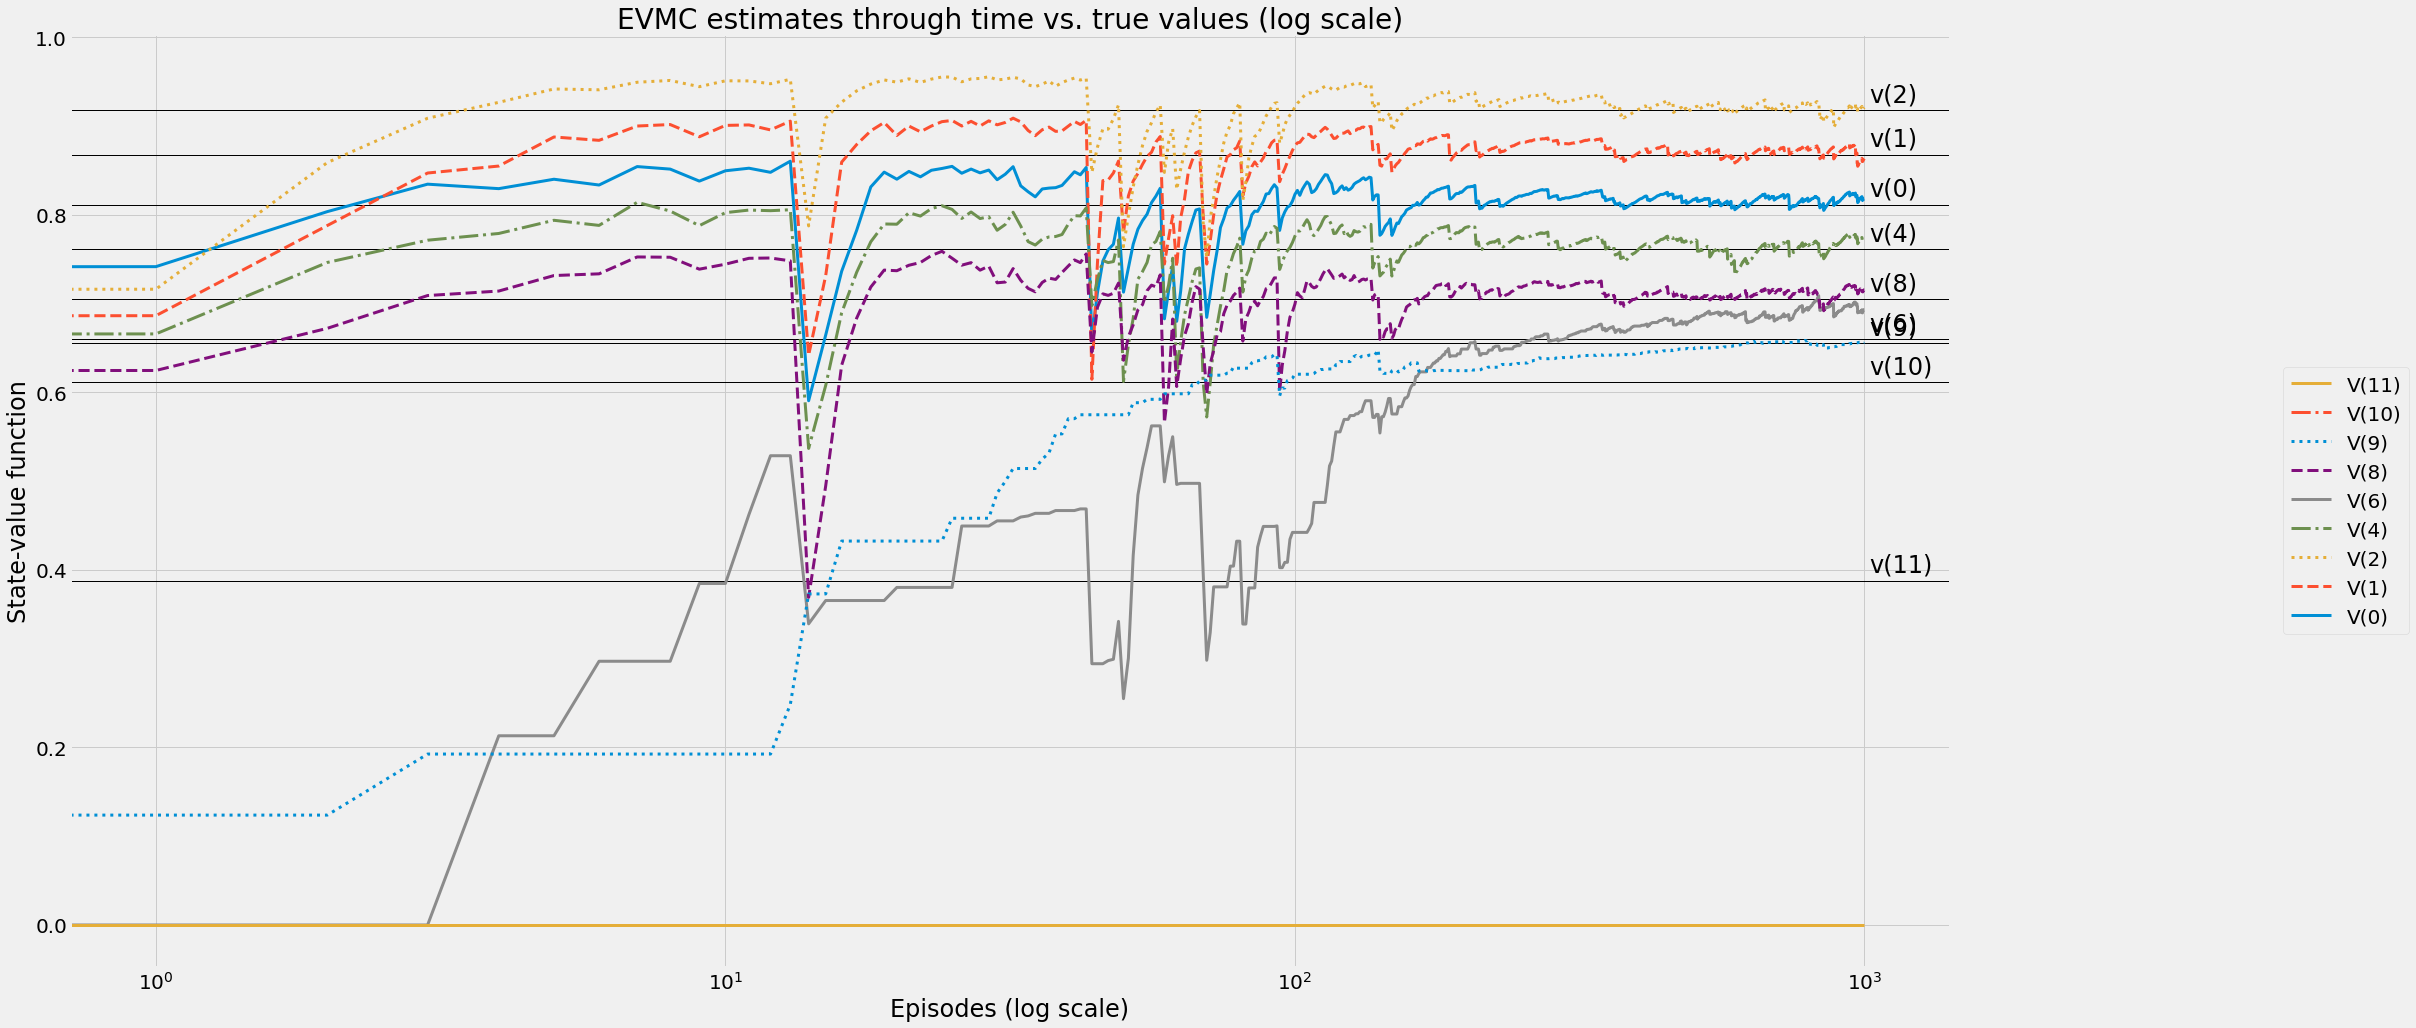

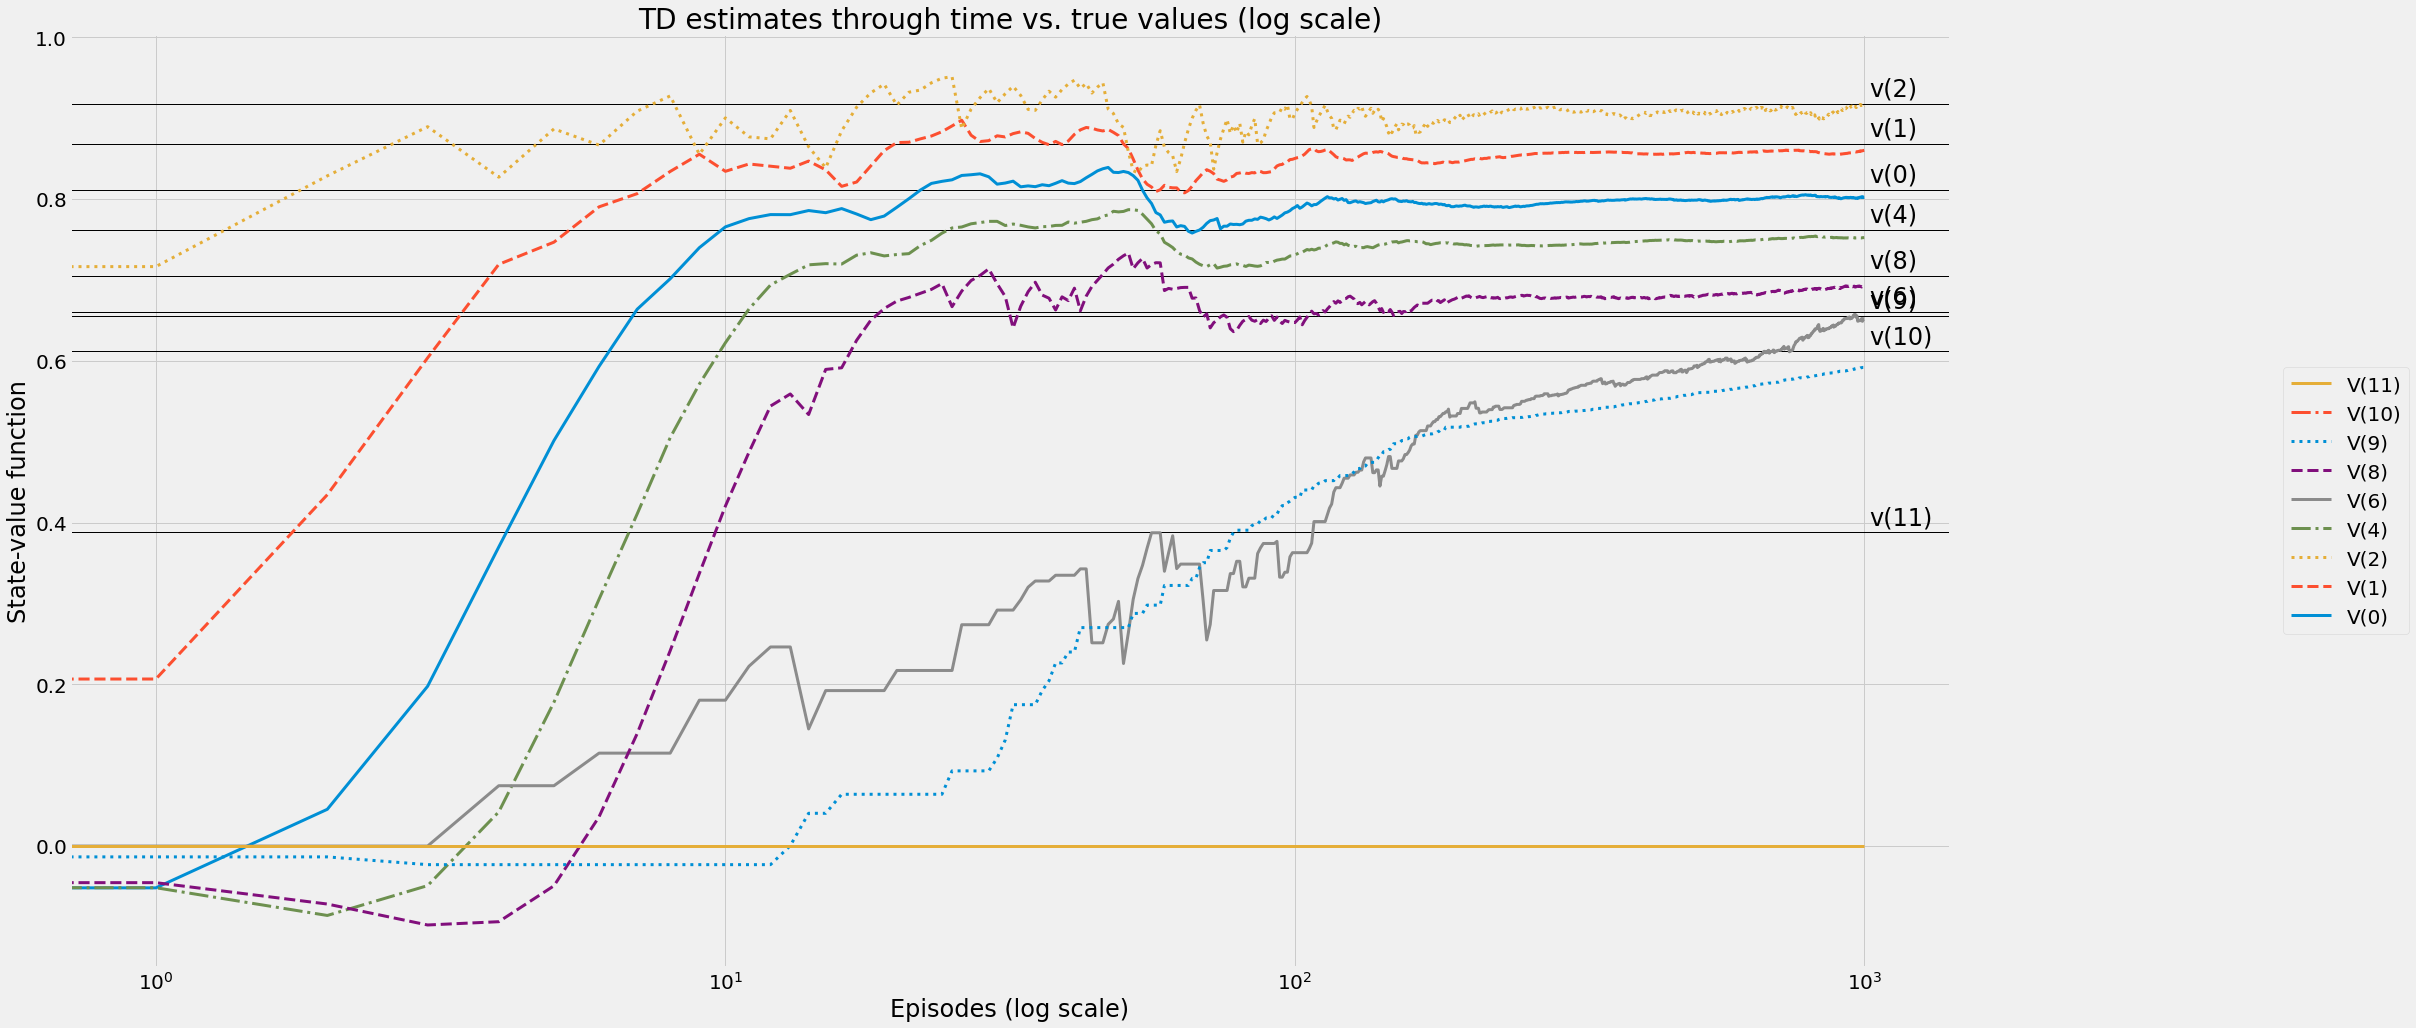

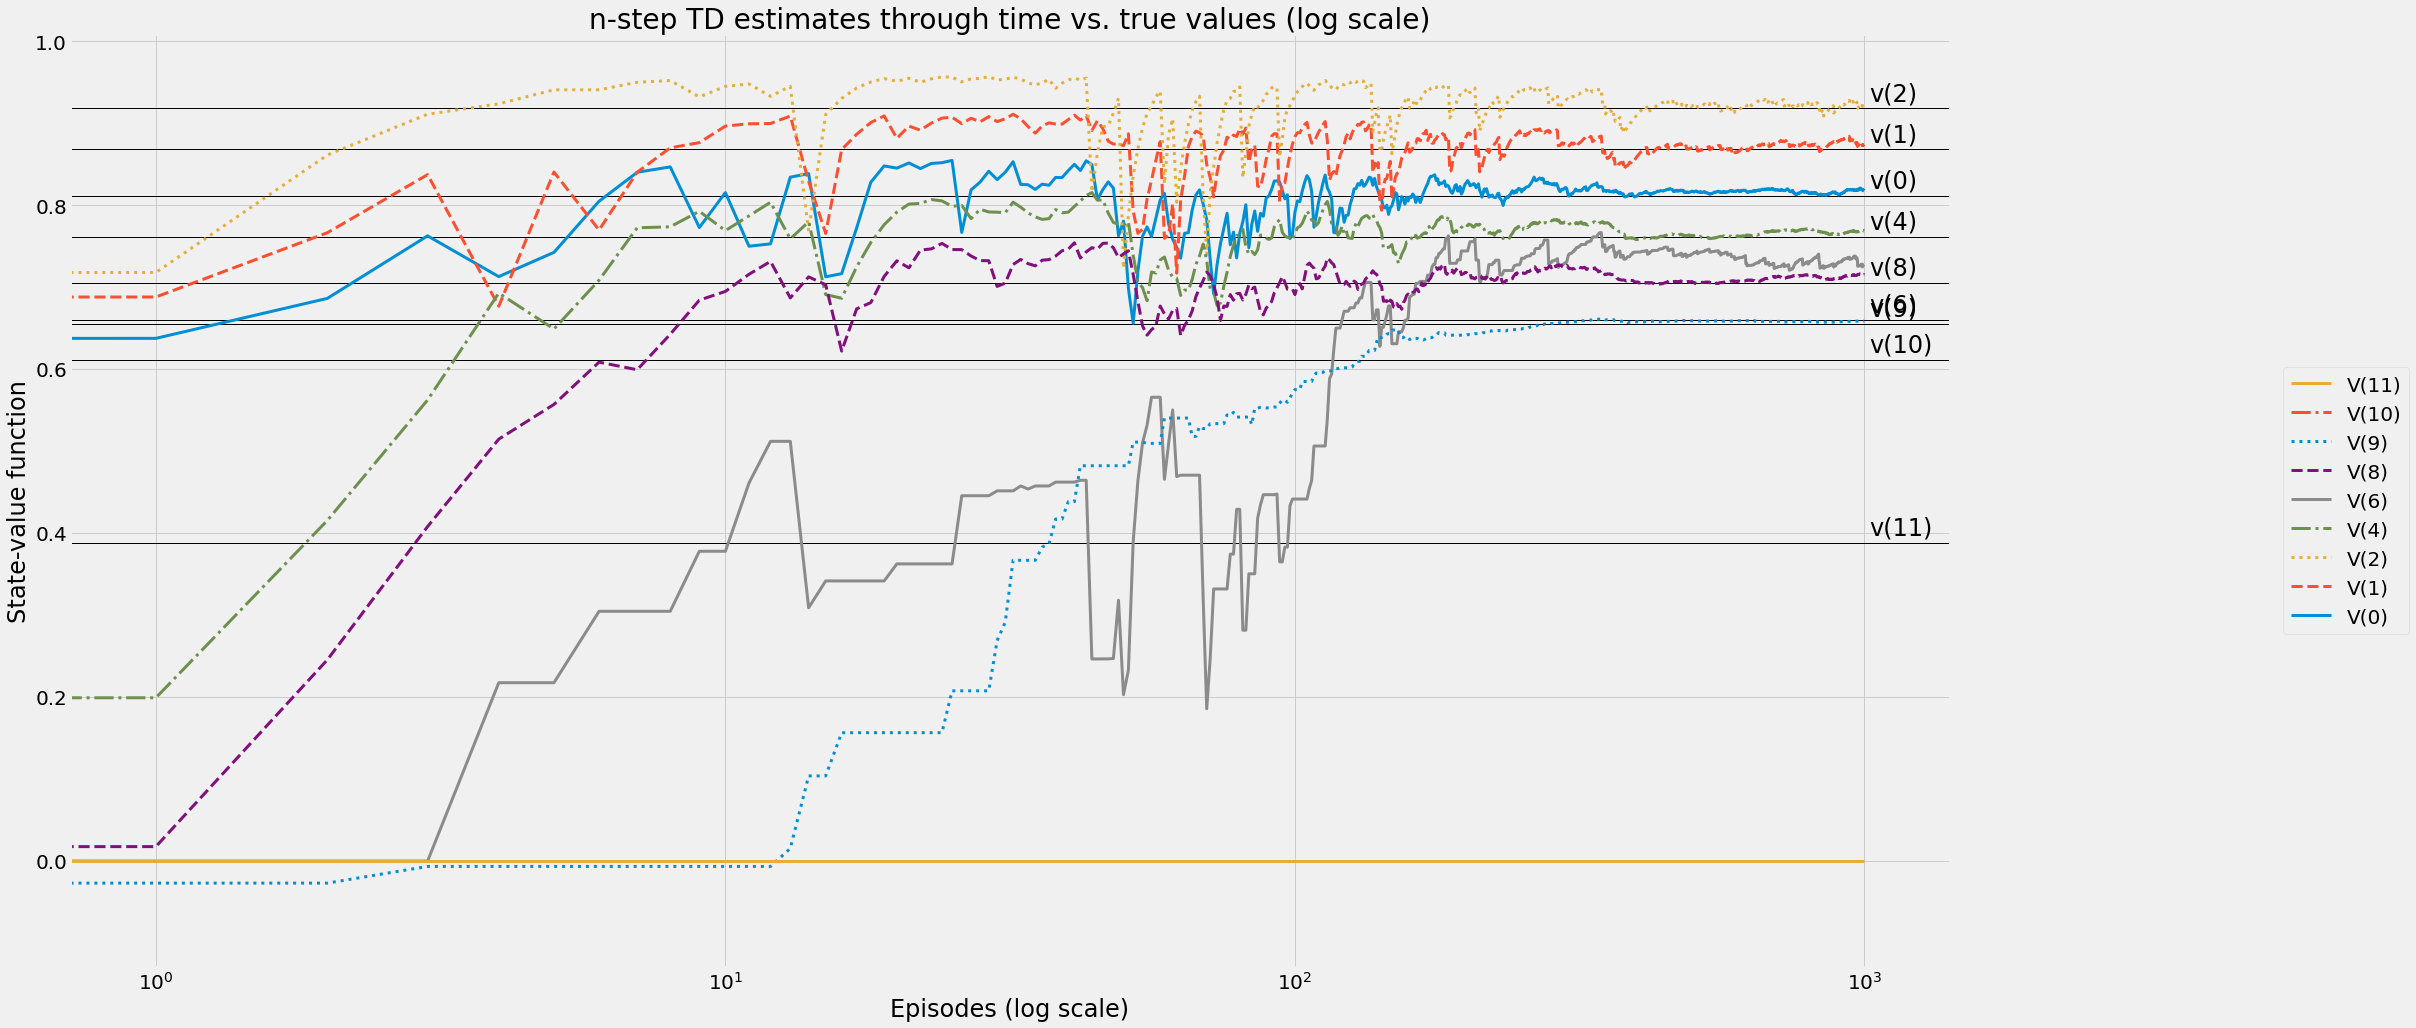

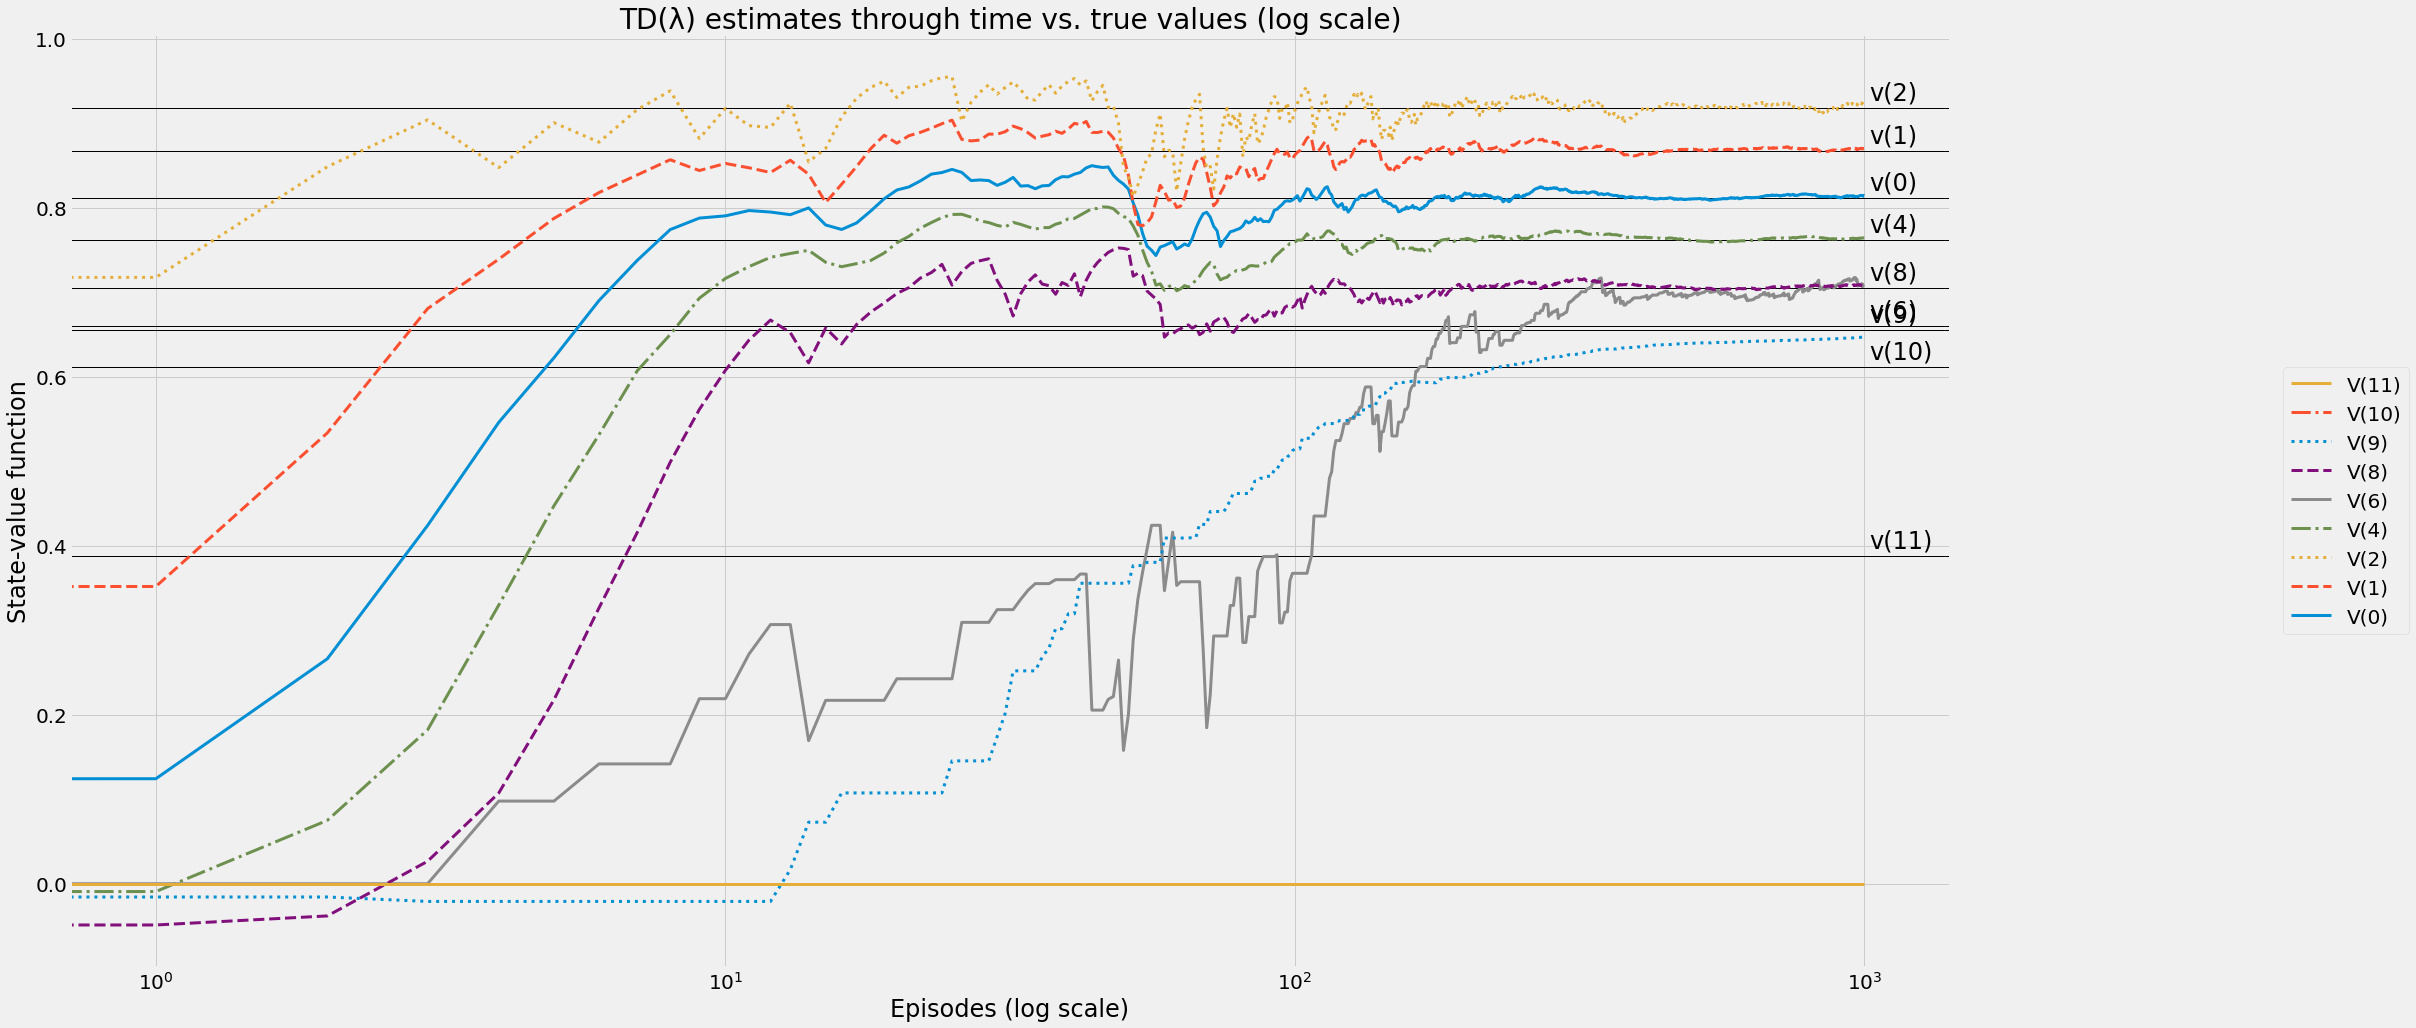

In [84]:
plot_value_function('FVMC estimates through time vs. true values (log scale)', V_track_fvmc, V_true, log=True, limit_items=10)
plot_value_function('EVMC estimates through time vs. true values (log scale)', V_track_evmc, V_true, log=True, limit_items=10)
plot_value_function('TD estimates through time vs. true values (log scale)', V_track_td, V_true, log=True, limit_items=10)
plot_value_function('n-step TD estimates through time vs. true values (log scale)', V_track_ntd, V_true, log=True, limit_items=10)
plot_value_function('TD(λ) estimates through time vs. true values (log scale)', V_track_tdl, V_true, log=True, limit_items=10)